# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('etau_tree', {'root_raw/et18_raw/ggH_bbtt*.root', 'root_raw/et18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('etau_tree', {'root_raw/et17_raw/ggH_bbtt*.root', 'root_raw/et17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('etau_tree', {'root_raw/et16_raw/ggH_bbtt*.root', 'root_raw/et16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 2b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.2770')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3033')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3093')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mytau+mymet).Pt(),(myele+mytau+mymet).Eta(),(myele+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_2,beta_deepflavour_2,bphi_deepflavour_2,bm_deepflavour_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1ele = '(myele+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
m_b2ele = '(myele+myb2).M()'
m_b2tau = '(mytau+myb2).M()'
m_bbele = '(myb1+myb2+myele).M()'
m_bbtau = '(myb1+myb2+mytau).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mytau)'
dR_b1ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b2ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb2)'
dR_b2tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbele = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,myele)'
dR_bbtau = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mytau)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'

tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_ele = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt(),2)+pow(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mytau.Px())*x_zeta+(myele.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files17[i] = files17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files16[i] = files16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 ele+tau trigger requirements
trigger32_18 = '(passEle32 && pt_1>33 && matchEle32_1 && filterEle32_1)'
trigger35_18 = '(passEle35 && pt_1>33 && matchEle35_1 && filterEle35_1)'
trigger2430_18 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_18 = '(passEle24HPSTau30 && matchEle24HPSTau30_1 && filterEle24HPSTau30_1 && matchEle24HPSTau30_2 && filterEle24HPSTau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_emb_18 = '(matchEmbFilter_Ele24Tau30_1 && matchEmbFilter_Ele24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'

trigger_mc_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_1_18 = trigger2430_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_2_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_emb_18 = trigger2430HPS_emb_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files18[1] = files18[1].Filter('gen_match_1==3 && gen_match_2==5')#reconstructed taus are gen taus
files18[1] = files18[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger32_17 = '(passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_17 = '(passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_17 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
# requirements on embedded
trigger32_emb1_17 = '(fabs(eta_1)<1.479 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_emb1_17 = '(fabs(eta_1)<1.479 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_emb1_17 = '(fabs(eta_1)<1.479 && passEle24Tau30 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
triggersingle_emb2_17 = '(fabs(eta_1)>1.479 && ((pt_1>28 && pt_1<40) or (pt_1>40 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1) or (pt_1>40 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)))'
triggercross_emb2_17 = '(fabs(eta_1)>1.479 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger2430_17 + str(' or ') + trigger32_17 + str(' or ') + trigger27_17
trigger_emb_17 = trigger32_emb1_17 + str(' or ') + trigger27_emb1_17 + str(' or ') + trigger2430_emb1_17 + str(' or ') + triggersingle_emb2_17 + str(' or ') + triggercross_emb2_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files17[1] = files17[1].Filter('gen_match_1==3 && gen_match_2==5')#reconstructed taus are gen taus
files17[1] = files17[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger25_16 = '(passEle25 && matchEle25_1 && filterEle25_1 && pt_1>26)'

trigger_all_16 = trigger25_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files16[1] = files16[1].Filter('gen_match_1==3 && gen_match_2==5')#reconstructed taus are gen taus
files16[1] = files16[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1ele', 'm_b1tau', 'm_b2ele', 'm_b2tau', 'dm_a',\
                'm_bbele', 'm_bbtau', 'dR_tt', 'dR_b1ele', 'dR_b1tau', 'dR_b2ele', 'dR_b2tau', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbele','dR_bbtau', 'mT_ele', 'mT_tau', 'mT_b1', 'mT_b2', 'Dzeta',\
                'bpt_deepflavour_1', 'bpt_deepflavour_2']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (3139, 30)
ZTT18.shape  : (12534, 30)
TT18.shape   : (312605, 30)
qcd18_1.shape: (10453, 30)
qcd18_2.shape: (23063, 30)

sig17.shape  : (4286, 30)
ZTT17.shape  : (13763, 30)
TT17.shape   : (49657, 30)
qcd17.shape  : (23664, 30)

sig16.shape  : (2621, 30)
ZTT16.shape  : (5866, 30)
TT16.shape   : (257948, 30)
qcd16.shape  : (16350, 30)

sig_allyears.shape: (10046, 31)
ZTT_allyears.shape: (32163, 31)
TT_allyears.shape : (620210, 31)
qcd_allyears.shape: (73530, 31)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 482, random_state = 20)#4.8%
TT_allyears = TT_allyears.sample(n = 7334, random_state = 20)#73%
qcd_allyears = qcd_allyears.sample(n = 2230, random_state = 20)#22.2%

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1      m_b1tt      m_b2tt      m_bbtt        m_bb     m_b1ele  \
0      36.171391  152.216275   99.714663  184.717134   38.068157   99.559879   
1      34.209496   89.105404   80.758617  119.327529   15.200355   57.242104   
2      39.051136  137.970615  127.276051  185.702597   22.276673   72.669346   
3      39.627846  125.824320   80.155630  149.093362   24.203104   85.805851   
4      36.637619  105.532988   83.509246  133.076147   18.532795   72.200576   
...          ...         ...         ...         ...         ...         ...   
13534  79.488663  193.458001  450.730989  483.633963  151.503629   60.834434   
4897   62.597054  169.556487  200.205325  241.734457   92.148498  101.255519   
4629   47.337147  314.322288  319.665876  357.376722   49.983749   29.617402   
6938   35.693420  167.176300  125.215543  214.759205   59.145297   91.098321   
6909   52.569817  170.845938  144.409095  223.006237   69.318958  117.139110   

          m_b1tau     m

## Compare input feature distributions between sig and bkg

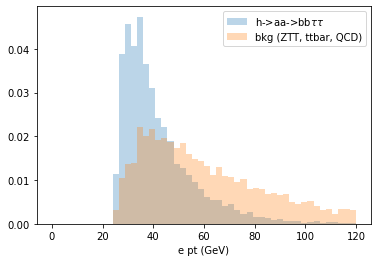

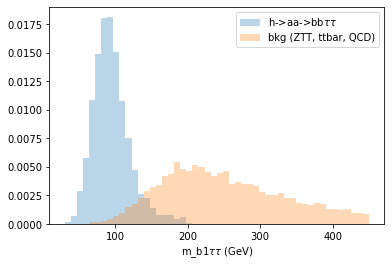

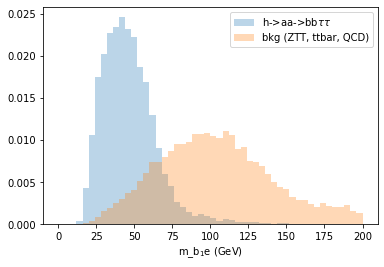

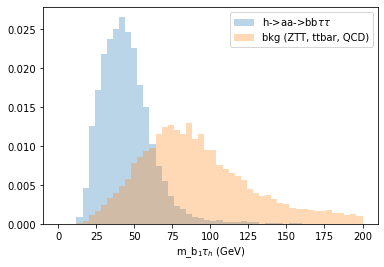

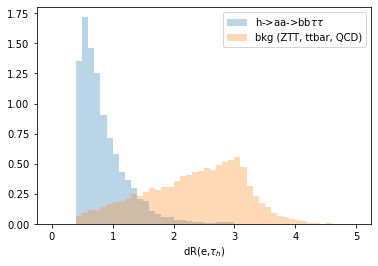

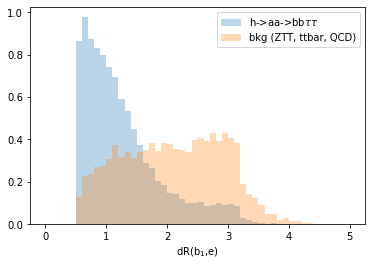

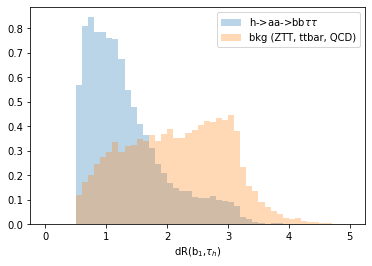

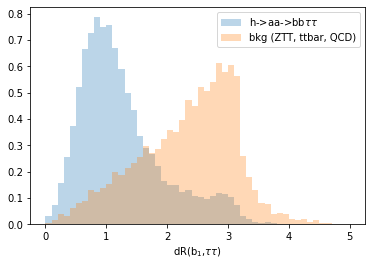

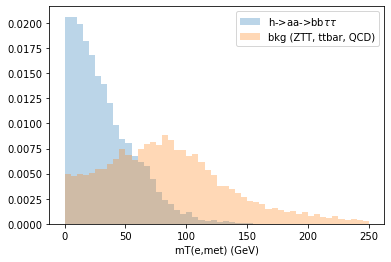

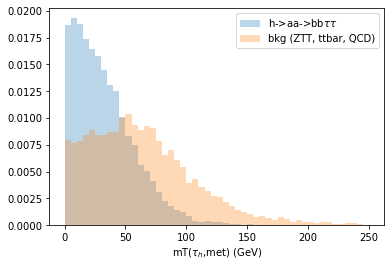

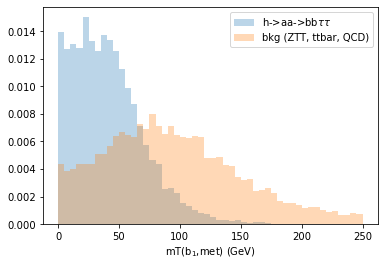

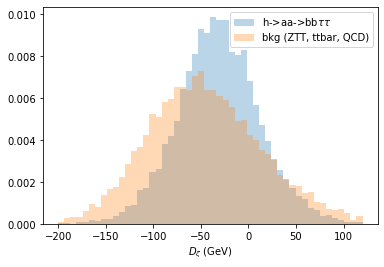

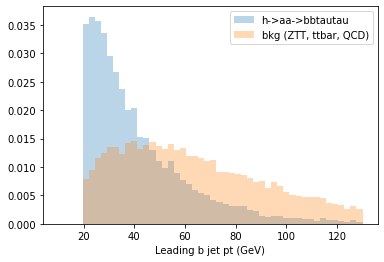

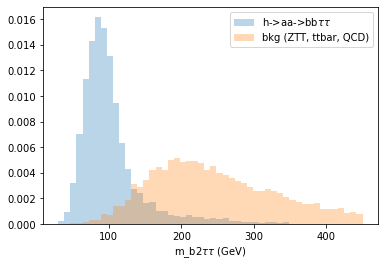

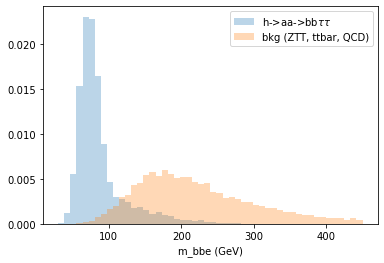

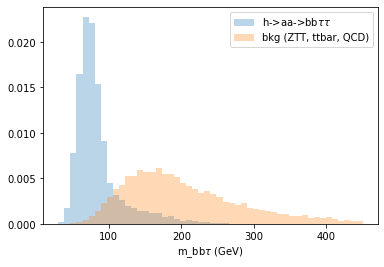

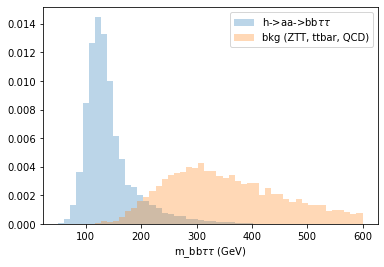

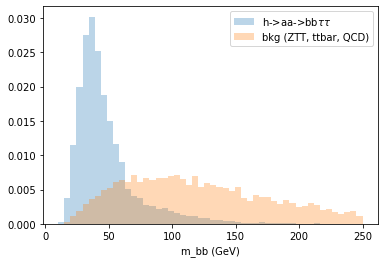

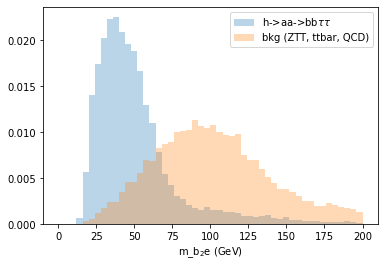

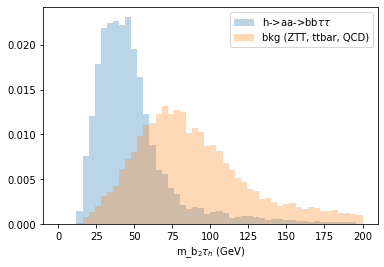

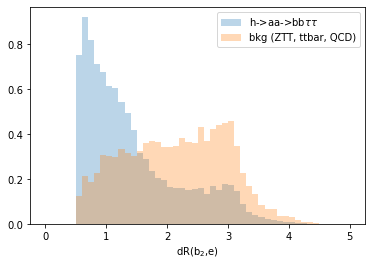

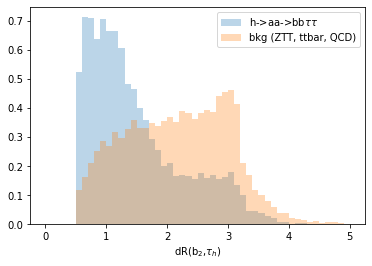

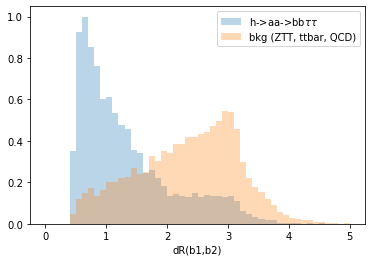

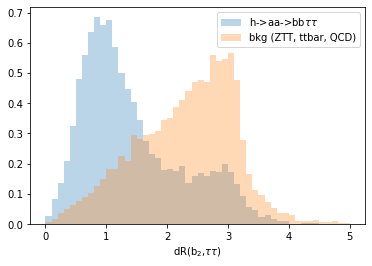

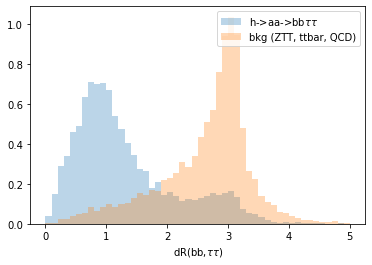

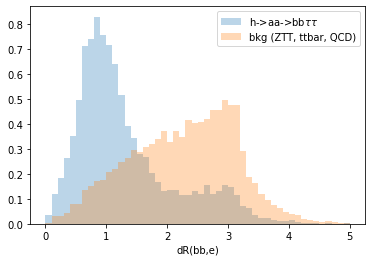

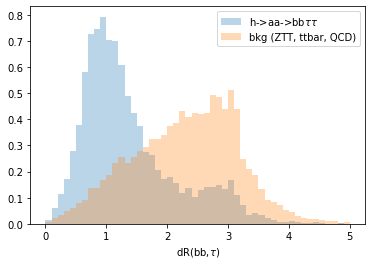

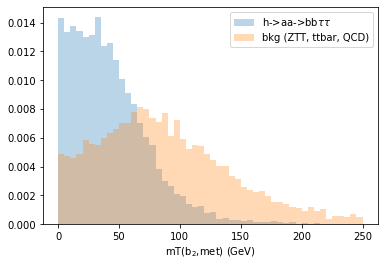

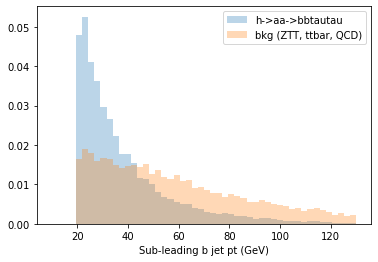

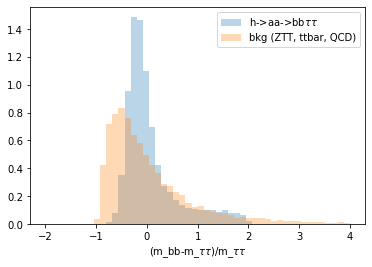

"\npyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')\npyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')\n#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')\n#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')\n#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')\npyplot.legend(loc = 'upper right')\npyplot.xlabel('$\\tau\\tau$ pt (GeV)')\npyplot.show()\n\npyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')\npyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')\n#pyplot.hist(ZTT_allyears['tt_eta'], den

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

############## for 2b events
pyplot.hist(sig_allyears['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbele'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbele'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bbe (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()



'''
pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()
'''

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.50/0.25/0.25
X_train.shape: (10046, 30)
Y_train.shape: (10046, 1)
X_val.shape: (5023, 30)
Y_val.shape: (5023, 1)
X_test.shape: (5023, 30)
Y_test.shape: (5023, 1)

Total number of sig/bkg examples: 10046/10046 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 5034/5012 (50.1%/49.9%)
val   : 2514/2509 (50.0%/50.0%)
test  : 2498/2525 (49.7%/50.3%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-08-28 12:39:49.858649: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-28 12:39:49.859101: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 128)

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 51s - loss: 0.6969 - accuracy: 0.562 - ETA: 5s - loss: 0.6183 - accuracy: 0.672 - ETA: 2s - loss: 0.5300 - accuracy: 0.76 - ETA: 1s - loss: 0.4637 - accuracy: 0.81 - ETA: 1s - loss: 0.4138 - accuracy: 0.83 - ETA: 0s - loss: 0.3653 - accuracy: 0.85 - ETA: 0s - loss: 0.3313 - accuracy: 0.87 - ETA: 0s - loss: 0.3086 - accuracy: 0.88 - ETA: 0s - loss: 0.2896 - accuracy: 0.89 - 1s 137us/sample - loss: 0.2756 - accuracy: 0.8973 - val_loss: 0.1092 - val_accuracy: 0.9640
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.98 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 41s - loss: 0.7945 - accuracy: 0.507 - ETA: 4s - loss: 0.7067 - accuracy: 0.594 - ETA: 1s - loss: 0.6170 - accuracy: 0.65 - ETA: 1s - loss: 0.5516 - accuracy: 0.71 - ETA: 0s - loss: 0.4971 - accuracy: 0.75 - ETA: 0s - loss: 0.4591 - accuracy: 0.78 - ETA: 0s - loss: 0.4293 - accuracy: 0.79 - ETA: 0s - loss: 0.4055 - accuracy: 0.81 - ETA: 0s - loss: 0.3864 - accuracy: 0.82 - 1s 123us/sample - loss: 0.3774 - accuracy: 0.8302 - val_loss: 0.1466 - val_accuracy: 0.9470
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.95 - ETA: 0s - loss: 0.1908 - accuracy: 0.92 - ETA: 0s - loss: 0.1860 - accuracy: 0.92 - ETA: 0s - loss: 0.1860 - accuracy: 0.92 - ETA: 0s - loss: 0.1849 - accuracy: 0.93 - ETA: 0s - loss: 0.1815 - accuracy: 0.93 - ETA: 0s - loss: 0.1778 - accuracy: 0.93 - ETA: 0s - loss: 0.1738 - accuracy: 0.93 - ETA: 0s - loss: 0.1700 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 40s - loss: 0.6683 - accuracy: 0.531 - ETA: 3s - loss: 0.5744 - accuracy: 0.664 - ETA: 1s - loss: 0.5062 - accuracy: 0.75 - ETA: 1s - loss: 0.4595 - accuracy: 0.79 - ETA: 0s - loss: 0.4157 - accuracy: 0.82 - ETA: 0s - loss: 0.3718 - accuracy: 0.85 - ETA: 0s - loss: 0.3392 - accuracy: 0.86 - ETA: 0s - loss: 0.3167 - accuracy: 0.87 - ETA: 0s - loss: 0.2943 - accuracy: 0.88 - 1s 121us/sample - loss: 0.2794 - accuracy: 0.8904 - val_loss: 0.1089 - val_accuracy: 0.9602
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.94 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 42s - loss: 0.6913 - accuracy: 0.609 - ETA: 4s - loss: 0.6058 - accuracy: 0.667 - ETA: 2s - loss: 0.5085 - accuracy: 0.76 - ETA: 1s - loss: 0.4440 - accuracy: 0.81 - ETA: 1s - loss: 0.4000 - accuracy: 0.83 - ETA: 0s - loss: 0.3667 - accuracy: 0.85 - ETA: 0s - loss: 0.3418 - accuracy: 0.86 - ETA: 0s - loss: 0.3176 - accuracy: 0.87 - ETA: 0s - loss: 0.2987 - accuracy: 0.88 - ETA: 0s - loss: 0.2802 - accuracy: 0.89 - 1s 126us/sample - loss: 0.2705 - accuracy: 0.8964 - val_loss: 0.1051 - val_accuracy: 0.9636
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1442 - accuracy: 0.94 - ETA: 0s - loss: 0.1347 - accuracy: 0.94 - ETA: 0s - loss: 0.1324 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7848 - accuracy: 0.460 - ETA: 3s - loss: 0.6074 - accuracy: 0.651 - ETA: 1s - loss: 0.5173 - accuracy: 0.74 - ETA: 0s - loss: 0.4520 - accuracy: 0.79 - ETA: 0s - loss: 0.4027 - accuracy: 0.82 - ETA: 0s - loss: 0.3668 - accuracy: 0.84 - ETA: 0s - loss: 0.3362 - accuracy: 0.86 - ETA: 0s - loss: 0.3114 - accuracy: 0.87 - 1s 113us/sample - loss: 0.2957 - accuracy: 0.8801 - val_loss: 0.1111 - val_accuracy: 0.9600
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.93 - ETA: 0s - loss: 0.1401 - accuracy: 0.94 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1257 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - 1s 54us/sample - loss: 0.119

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7308 - accuracy: 0.523 - ETA: 3s - loss: 0.5885 - accuracy: 0.658 - ETA: 1s - loss: 0.4991 - accuracy: 0.74 - ETA: 0s - loss: 0.4353 - accuracy: 0.79 - ETA: 0s - loss: 0.3834 - accuracy: 0.82 - ETA: 0s - loss: 0.3462 - accuracy: 0.85 - ETA: 0s - loss: 0.3196 - accuracy: 0.86 - ETA: 0s - loss: 0.2959 - accuracy: 0.87 - 1s 113us/sample - loss: 0.2823 - accuracy: 0.8841 - val_loss: 0.1123 - val_accuracy: 0.9596
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.98 - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1255 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - 1s 53us/sample - loss: 0.1136 - accuracy: 0.9612 - val_loss: 0.0867 - 

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 38s - loss: 0.7358 - accuracy: 0.562 - ETA: 3s - loss: 0.5782 - accuracy: 0.703 - ETA: 1s - loss: 0.4987 - accuracy: 0.76 - ETA: 1s - loss: 0.4368 - accuracy: 0.80 - ETA: 0s - loss: 0.3967 - accuracy: 0.83 - ETA: 0s - loss: 0.3608 - accuracy: 0.85 - ETA: 0s - loss: 0.3318 - accuracy: 0.86 - ETA: 0s - loss: 0.3111 - accuracy: 0.87 - ETA: 0s - loss: 0.2921 - accuracy: 0.88 - 1s 115us/sample - loss: 0.2878 - accuracy: 0.8846 - val_loss: 0.1148 - val_accuracy: 0.9568
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.94 - ETA: 0s - loss: 0.1438 - accuracy: 0.94 - ETA: 0s - loss: 0.1392 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - accuracy: 0.94 - ETA: 0s - loss: 0.1375 - accuracy: 0.94 - ETA: 0s - loss: 0.1353 - accuracy: 0.94 - ETA: 0s - loss: 0.1335 - accuracy: 0.94 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 38s - loss: 0.8295 - accuracy: 0.382 - ETA: 3s - loss: 0.6449 - accuracy: 0.639 - ETA: 1s - loss: 0.5272 - accuracy: 0.75 - ETA: 1s - loss: 0.4640 - accuracy: 0.80 - ETA: 0s - loss: 0.4170 - accuracy: 0.82 - ETA: 0s - loss: 0.3749 - accuracy: 0.84 - ETA: 0s - loss: 0.3412 - accuracy: 0.86 - ETA: 0s - loss: 0.3140 - accuracy: 0.87 - ETA: 0s - loss: 0.2900 - accuracy: 0.88 - 1s 117us/sample - loss: 0.2817 - accuracy: 0.8883 - val_loss: 0.1071 - val_accuracy: 0.9640
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.94 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1082 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 38s - loss: 0.7303 - accuracy: 0.468 - ETA: 3s - loss: 0.6044 - accuracy: 0.682 - ETA: 1s - loss: 0.5142 - accuracy: 0.77 - ETA: 1s - loss: 0.4481 - accuracy: 0.81 - ETA: 0s - loss: 0.3950 - accuracy: 0.84 - ETA: 0s - loss: 0.3552 - accuracy: 0.86 - ETA: 0s - loss: 0.3213 - accuracy: 0.87 - ETA: 0s - loss: 0.2935 - accuracy: 0.89 - ETA: 0s - loss: 0.2740 - accuracy: 0.89 - 1s 116us/sample - loss: 0.2633 - accuracy: 0.9020 - val_loss: 0.1016 - val_accuracy: 0.9638
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 38s - loss: 0.7540 - accuracy: 0.484 - ETA: 3s - loss: 0.5898 - accuracy: 0.703 - ETA: 1s - loss: 0.4615 - accuracy: 0.80 - ETA: 1s - loss: 0.3910 - accuracy: 0.84 - ETA: 0s - loss: 0.3417 - accuracy: 0.86 - ETA: 0s - loss: 0.3025 - accuracy: 0.88 - ETA: 0s - loss: 0.2756 - accuracy: 0.89 - ETA: 0s - loss: 0.2531 - accuracy: 0.90 - ETA: 0s - loss: 0.2355 - accuracy: 0.90 - 1s 116us/sample - loss: 0.2285 - accuracy: 0.9117 - val_loss: 0.0915 - val_accuracy: 0.9654
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.98 - ETA: 0s - loss: 0.1071 - accuracy: 0.95 - ETA: 0s - loss: 0.1030 - accuracy: 0.95 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 38s - loss: 0.7304 - accuracy: 0.539 - ETA: 3s - loss: 0.5218 - accuracy: 0.744 - ETA: 1s - loss: 0.4341 - accuracy: 0.82 - ETA: 1s - loss: 0.3784 - accuracy: 0.85 - ETA: 0s - loss: 0.3315 - accuracy: 0.87 - ETA: 0s - loss: 0.2978 - accuracy: 0.89 - ETA: 0s - loss: 0.2754 - accuracy: 0.90 - ETA: 0s - loss: 0.2549 - accuracy: 0.90 - ETA: 0s - loss: 0.2412 - accuracy: 0.91 - 1s 118us/sample - loss: 0.2271 - accuracy: 0.9191 - val_loss: 0.0925 - val_accuracy: 0.9668
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 38s - loss: 0.6547 - accuracy: 0.523 - ETA: 3s - loss: 0.5290 - accuracy: 0.769 - ETA: 1s - loss: 0.4323 - accuracy: 0.83 - ETA: 1s - loss: 0.3672 - accuracy: 0.86 - ETA: 0s - loss: 0.3231 - accuracy: 0.88 - ETA: 0s - loss: 0.2939 - accuracy: 0.89 - ETA: 0s - loss: 0.2657 - accuracy: 0.90 - ETA: 0s - loss: 0.2460 - accuracy: 0.91 - ETA: 0s - loss: 0.2299 - accuracy: 0.91 - 1s 117us/sample - loss: 0.2188 - accuracy: 0.9219 - val_loss: 0.0930 - val_accuracy: 0.9660
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.95 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0906 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - accuracy: 0.96 - ETA: 0s - loss: 0.0907 - accuracy: 0.96 - ETA: 0s - loss: 0.0882 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 38s - loss: 0.7250 - accuracy: 0.484 - ETA: 3s - loss: 0.5151 - accuracy: 0.755 - ETA: 1s - loss: 0.4200 - accuracy: 0.82 - ETA: 1s - loss: 0.3545 - accuracy: 0.86 - ETA: 0s - loss: 0.3097 - accuracy: 0.88 - ETA: 0s - loss: 0.2794 - accuracy: 0.89 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - ETA: 0s - loss: 0.2351 - accuracy: 0.91 - ETA: 0s - loss: 0.2204 - accuracy: 0.91 - 1s 116us/sample - loss: 0.2154 - accuracy: 0.9213 - val_loss: 0.0938 - val_accuracy: 0.9656
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.94 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 38s - loss: 0.7613 - accuracy: 0.484 - ETA: 3s - loss: 0.5827 - accuracy: 0.714 - ETA: 1s - loss: 0.4683 - accuracy: 0.79 - ETA: 1s - loss: 0.4017 - accuracy: 0.83 - ETA: 0s - loss: 0.3552 - accuracy: 0.85 - ETA: 0s - loss: 0.3165 - accuracy: 0.87 - ETA: 0s - loss: 0.2868 - accuracy: 0.88 - ETA: 0s - loss: 0.2634 - accuracy: 0.89 - ETA: 0s - loss: 0.2473 - accuracy: 0.90 - 1s 119us/sample - loss: 0.2330 - accuracy: 0.9082 - val_loss: 0.0945 - val_accuracy: 0.9660
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 0s - loss: 0.0910 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 38s - loss: 0.7435 - accuracy: 0.523 - ETA: 3s - loss: 0.6098 - accuracy: 0.650 - ETA: 1s - loss: 0.5200 - accuracy: 0.72 - ETA: 1s - loss: 0.4544 - accuracy: 0.78 - ETA: 0s - loss: 0.4066 - accuracy: 0.81 - ETA: 0s - loss: 0.3695 - accuracy: 0.83 - ETA: 0s - loss: 0.3417 - accuracy: 0.85 - ETA: 0s - loss: 0.3217 - accuracy: 0.86 - ETA: 0s - loss: 0.3048 - accuracy: 0.86 - 1s 117us/sample - loss: 0.2921 - accuracy: 0.8766 - val_loss: 0.1102 - val_accuracy: 0.9608
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.92 - ETA: 0s - loss: 0.1396 - accuracy: 0.95 - ETA: 0s - loss: 0.1409 - accuracy: 0.94 - ETA: 0s - loss: 0.1357 - accuracy: 0.94 - ETA: 0s - loss: 0.1337 - accuracy: 0.94 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 38s - loss: 0.7023 - accuracy: 0.617 - ETA: 3s - loss: 0.5855 - accuracy: 0.690 - ETA: 1s - loss: 0.4863 - accuracy: 0.76 - ETA: 1s - loss: 0.4150 - accuracy: 0.81 - ETA: 0s - loss: 0.3668 - accuracy: 0.83 - ETA: 0s - loss: 0.3288 - accuracy: 0.85 - ETA: 0s - loss: 0.3030 - accuracy: 0.87 - ETA: 0s - loss: 0.2815 - accuracy: 0.88 - ETA: 0s - loss: 0.2613 - accuracy: 0.89 - 1s 116us/sample - loss: 0.2572 - accuracy: 0.8932 - val_loss: 0.0973 - val_accuracy: 0.9664
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.92 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1098 - accuracy: 0.95 - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 38s - loss: 0.6932 - accuracy: 0.476 - ETA: 3s - loss: 0.5322 - accuracy: 0.752 - ETA: 1s - loss: 0.4283 - accuracy: 0.82 - ETA: 1s - loss: 0.3651 - accuracy: 0.85 - ETA: 0s - loss: 0.3145 - accuracy: 0.88 - ETA: 0s - loss: 0.2863 - accuracy: 0.89 - ETA: 0s - loss: 0.2541 - accuracy: 0.90 - ETA: 0s - loss: 0.2361 - accuracy: 0.91 - ETA: 0s - loss: 0.2190 - accuracy: 0.92 - 1s 118us/sample - loss: 0.2041 - accuracy: 0.9251 - val_loss: 0.0874 - val_accuracy: 0.9652
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.98 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0909 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0882 - accuracy: 0.96 - ETA: 0s - loss: 0.0870 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0858 - a

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 47s - loss: 0.7425 - accuracy: 0.515 - ETA: 5s - loss: 0.5825 - accuracy: 0.728 - ETA: 2s - loss: 0.4813 - accuracy: 0.81 - ETA: 1s - loss: 0.4134 - accuracy: 0.84 - ETA: 1s - loss: 0.3634 - accuracy: 0.86 - ETA: 0s - loss: 0.3243 - accuracy: 0.88 - ETA: 0s - loss: 0.2931 - accuracy: 0.89 - ETA: 0s - loss: 0.2687 - accuracy: 0.90 - ETA: 0s - loss: 0.2490 - accuracy: 0.91 - ETA: 0s - loss: 0.2340 - accuracy: 0.91 - 1s 131us/sample - loss: 0.2293 - accuracy: 0.9171 - val_loss: 0.0905 - val_accuracy: 0.9681
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.95 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - a

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 41s - loss: 0.7214 - accuracy: 0.523 - ETA: 4s - loss: 0.6411 - accuracy: 0.577 - ETA: 2s - loss: 0.5595 - accuracy: 0.68 - ETA: 1s - loss: 0.4908 - accuracy: 0.75 - ETA: 0s - loss: 0.4388 - accuracy: 0.79 - ETA: 0s - loss: 0.3961 - accuracy: 0.82 - ETA: 0s - loss: 0.3629 - accuracy: 0.84 - ETA: 0s - loss: 0.3348 - accuracy: 0.85 - ETA: 0s - loss: 0.3092 - accuracy: 0.87 - 1s 122us/sample - loss: 0.2934 - accuracy: 0.8775 - val_loss: 0.1149 - val_accuracy: 0.9588
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.98 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1203 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1121 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7156 - accuracy: 0.609 - ETA: 3s - loss: 0.5512 - accuracy: 0.758 - ETA: 1s - loss: 0.4521 - accuracy: 0.82 - ETA: 1s - loss: 0.3853 - accuracy: 0.85 - ETA: 0s - loss: 0.3363 - accuracy: 0.87 - ETA: 0s - loss: 0.3042 - accuracy: 0.89 - ETA: 0s - loss: 0.2777 - accuracy: 0.90 - ETA: 0s - loss: 0.2543 - accuracy: 0.90 - ETA: 0s - loss: 0.2377 - accuracy: 0.91 - 1s 119us/sample - loss: 0.2296 - accuracy: 0.9178 - val_loss: 0.0901 - val_accuracy: 0.9677
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.94 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.95 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 38s - loss: 0.7209 - accuracy: 0.539 - ETA: 3s - loss: 0.6696 - accuracy: 0.519 - ETA: 1s - loss: 0.5784 - accuracy: 0.62 - ETA: 1s - loss: 0.5087 - accuracy: 0.70 - ETA: 0s - loss: 0.4482 - accuracy: 0.76 - ETA: 0s - loss: 0.4017 - accuracy: 0.80 - ETA: 0s - loss: 0.3694 - accuracy: 0.82 - ETA: 0s - loss: 0.3440 - accuracy: 0.83 - ETA: 0s - loss: 0.3238 - accuracy: 0.84 - 1s 115us/sample - loss: 0.3166 - accuracy: 0.8530 - val_loss: 0.1204 - val_accuracy: 0.9576
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.94 - ETA: 0s - loss: 0.1491 - accuracy: 0.94 - ETA: 0s - loss: 0.1409 - accuracy: 0.94 - ETA: 0s - loss: 0.1349 - accuracy: 0.94 - ETA: 0s - loss: 0.1336 - accuracy: 0.94 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.9082 - accuracy: 0.335 - ETA: 3s - loss: 0.7255 - accuracy: 0.522 - ETA: 1s - loss: 0.6047 - accuracy: 0.65 - ETA: 1s - loss: 0.5140 - accuracy: 0.73 - ETA: 0s - loss: 0.4484 - accuracy: 0.78 - ETA: 0s - loss: 0.4017 - accuracy: 0.81 - ETA: 0s - loss: 0.3614 - accuracy: 0.83 - ETA: 0s - loss: 0.3304 - accuracy: 0.84 - ETA: 0s - loss: 0.3084 - accuracy: 0.86 - 1s 114us/sample - loss: 0.3053 - accuracy: 0.8639 - val_loss: 0.1042 - val_accuracy: 0.9632
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.92 - ETA: 0s - loss: 0.1361 - accuracy: 0.94 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 38s - loss: 0.6872 - accuracy: 0.554 - ETA: 3s - loss: 0.5556 - accuracy: 0.716 - ETA: 1s - loss: 0.4639 - accuracy: 0.79 - ETA: 1s - loss: 0.4107 - accuracy: 0.82 - ETA: 0s - loss: 0.3669 - accuracy: 0.84 - ETA: 0s - loss: 0.3313 - accuracy: 0.86 - ETA: 0s - loss: 0.3067 - accuracy: 0.87 - ETA: 0s - loss: 0.2858 - accuracy: 0.88 - ETA: 0s - loss: 0.2678 - accuracy: 0.89 - 1s 116us/sample - loss: 0.2608 - accuracy: 0.8954 - val_loss: 0.1053 - val_accuracy: 0.9626
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.98 - ETA: 0s - loss: 0.0959 - accuracy: 0.97 - ETA: 0s - loss: 0.1063 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1116 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 38s - loss: 0.6770 - accuracy: 0.601 - ETA: 3s - loss: 0.5285 - accuracy: 0.758 - ETA: 1s - loss: 0.4335 - accuracy: 0.83 - ETA: 1s - loss: 0.3739 - accuracy: 0.86 - ETA: 0s - loss: 0.3359 - accuracy: 0.87 - ETA: 0s - loss: 0.3027 - accuracy: 0.89 - ETA: 0s - loss: 0.2757 - accuracy: 0.90 - ETA: 0s - loss: 0.2574 - accuracy: 0.90 - ETA: 0s - loss: 0.2400 - accuracy: 0.91 - 1s 115us/sample - loss: 0.2354 - accuracy: 0.9178 - val_loss: 0.0931 - val_accuracy: 0.9666
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.97 - ETA: 0s - loss: 0.1063 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 38s - loss: 0.6993 - accuracy: 0.593 - ETA: 3s - loss: 0.5828 - accuracy: 0.668 - ETA: 1s - loss: 0.4851 - accuracy: 0.75 - ETA: 1s - loss: 0.4139 - accuracy: 0.80 - ETA: 0s - loss: 0.3654 - accuracy: 0.82 - ETA: 0s - loss: 0.3286 - accuracy: 0.84 - ETA: 0s - loss: 0.3020 - accuracy: 0.86 - ETA: 0s - loss: 0.2801 - accuracy: 0.87 - ETA: 0s - loss: 0.2621 - accuracy: 0.88 - 1s 118us/sample - loss: 0.2513 - accuracy: 0.8907 - val_loss: 0.0992 - val_accuracy: 0.9658
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.92 - ETA: 0s - loss: 0.1060 - accuracy: 0.95 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - a

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 38s - loss: 0.7419 - accuracy: 0.515 - ETA: 3s - loss: 0.6136 - accuracy: 0.666 - ETA: 1s - loss: 0.5366 - accuracy: 0.74 - ETA: 1s - loss: 0.4716 - accuracy: 0.78 - ETA: 0s - loss: 0.4237 - accuracy: 0.81 - ETA: 0s - loss: 0.3838 - accuracy: 0.83 - ETA: 0s - loss: 0.3533 - accuracy: 0.85 - ETA: 0s - loss: 0.3299 - accuracy: 0.86 - ETA: 0s - loss: 0.3074 - accuracy: 0.87 - 1s 116us/sample - loss: 0.3000 - accuracy: 0.8788 - val_loss: 0.1158 - val_accuracy: 0.9598
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.1203 - accuracy: 0.96 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - a

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.7941 - accuracy: 0.531 - ETA: 3s - loss: 0.6351 - accuracy: 0.669 - ETA: 1s - loss: 0.5353 - accuracy: 0.75 - ETA: 1s - loss: 0.4642 - accuracy: 0.80 - ETA: 0s - loss: 0.4159 - accuracy: 0.83 - ETA: 0s - loss: 0.3759 - accuracy: 0.84 - ETA: 0s - loss: 0.3446 - accuracy: 0.86 - ETA: 0s - loss: 0.3166 - accuracy: 0.87 - ETA: 0s - loss: 0.2972 - accuracy: 0.88 - 1s 118us/sample - loss: 0.2899 - accuracy: 0.8895 - val_loss: 0.1076 - val_accuracy: 0.9646
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.97 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accuracy: 0.96 - ETA: 0s - loss: 0.1133 - accuracy: 0.96 - ETA: 0s - loss: 0.1143 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 1.00 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0619 - accuracy: 0.97 - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - 1s 51us/sample - loss: 0.0597 - accuracy: 0.9779 - val_loss: 0.0567 - val_accuracy: 0.9795
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.98 - ETA: 0s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0551 - accuracy: 0.97 - ETA: 0s - loss: 0.0555 - accuracy: 0.97 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0560 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0568 - accuracy: 0.978

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 40s - loss: 0.5446 - accuracy: 0.718 - ETA: 3s - loss: 0.4658 - accuracy: 0.835 - ETA: 1s - loss: 0.3959 - accuracy: 0.87 - ETA: 1s - loss: 0.3472 - accuracy: 0.89 - ETA: 0s - loss: 0.3089 - accuracy: 0.90 - ETA: 0s - loss: 0.2784 - accuracy: 0.91 - ETA: 0s - loss: 0.2555 - accuracy: 0.92 - ETA: 0s - loss: 0.2343 - accuracy: 0.92 - ETA: 0s - loss: 0.2204 - accuracy: 0.93 - 1s 119us/sample - loss: 0.2133 - accuracy: 0.9338 - val_loss: 0.0932 - val_accuracy: 0.9668
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 1.00 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0520 - accuracy: 0.97 - ETA: 0s - loss: 0.0452 - accuracy: 0.98 - ETA: 0s - loss: 0.0471 - accuracy: 0.98 - ETA: 0s - loss: 0.0464 - accuracy: 0.98 - ETA: 0s - loss: 0.0465 - accuracy: 0.98 - ETA: 0s - loss: 0.0491 - accuracy: 0.97 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - 1s 54us/sample - loss: 0.0507 - accuracy: 0.9799 - val_loss: 0.0538 - val_accuracy: 0.9793
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 1.00 - ETA: 0s - loss: 0.0556 - accuracy: 0.98 - ETA: 0s - loss: 0.0476 - accuracy: 0.98 - ETA: 0s - loss: 0.0451 - accuracy: 0.98 - ETA: 0s - loss: 0.0445 - accuracy: 0.98 - ETA: 0s - loss: 0.0463 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0466 - accuracy: 0.98 - ETA: 0s - loss: 0.0473 - accuracy: 0.98 - 1s 53us/sample - loss: 0.0472 - accuracy: 0.981

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.6719 - accuracy: 0.601 - ETA: 3s - loss: 0.5698 - accuracy: 0.698 - ETA: 1s - loss: 0.4943 - accuracy: 0.76 - ETA: 1s - loss: 0.4282 - accuracy: 0.80 - ETA: 0s - loss: 0.3873 - accuracy: 0.83 - ETA: 0s - loss: 0.3569 - accuracy: 0.84 - ETA: 0s - loss: 0.3284 - accuracy: 0.86 - ETA: 0s - loss: 0.3073 - accuracy: 0.87 - ETA: 0s - loss: 0.2868 - accuracy: 0.88 - 1s 114us/sample - loss: 0.2843 - accuracy: 0.8857 - val_loss: 0.1112 - val_accuracy: 0.9644
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - ETA: 0s - loss: 0.1464 - accuracy: 0.94 - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.97 - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0625 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0588 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0580 - accuracy: 0.97 - 0s 50us/sample - loss: 0.0573 - accuracy: 0.9796 - val_loss: 0.0545 - val_accuracy: 0.9787
Epoch 18/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.98 - ETA: 0s - loss: 0.0537 - accuracy: 0.98 - ETA: 0s - loss: 0.0547 - accuracy: 0.98 - ETA: 0s - loss: 0.0578 - accuracy: 0.98 - ETA: 0s - loss: 0.0548 - accuracy: 0.98 - ETA: 0s - loss: 0.0590 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0558 - accuracy: 0.97 - 1s 50us/sample - loss: 0.0558 - accuracy: 0.9796 - val_loss: 0.0550 - val_accuracy: 0.9783
Epoch 19/20
10046/10046 [===============

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 40s - loss: 0.7379 - accuracy: 0.531 - ETA: 3s - loss: 0.6291 - accuracy: 0.631 - ETA: 1s - loss: 0.5341 - accuracy: 0.73 - ETA: 1s - loss: 0.4665 - accuracy: 0.78 - ETA: 0s - loss: 0.4150 - accuracy: 0.81 - ETA: 0s - loss: 0.3672 - accuracy: 0.84 - ETA: 0s - loss: 0.3378 - accuracy: 0.86 - ETA: 0s - loss: 0.3120 - accuracy: 0.87 - ETA: 0s - loss: 0.2903 - accuracy: 0.88 - 1s 117us/sample - loss: 0.2840 - accuracy: 0.8854 - val_loss: 0.1072 - val_accuracy: 0.9610
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.96 - ETA: 0s - loss: 0.1247 - accuracy: 0.96 - ETA: 0s - loss: 0.1215 - accuracy: 0.96 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.96 - ETA: 0s - loss: 0.1167 - accuracy: 0.96 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.96 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0622 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0596 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0603 - accuracy: 0.9783 - val_loss: 0.0575 - val_accuracy: 0.9787
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.96 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0559 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0589 - accuracy: 0.97 - ETA: 0s - loss: 0.0555 - accuracy: 0.97 - ETA: 0s - loss: 0.0549 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0578 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0582 - accuracy: 0.978

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.9836 - accuracy: 0.406 - ETA: 3s - loss: 0.7538 - accuracy: 0.581 - ETA: 1s - loss: 0.6439 - accuracy: 0.66 - ETA: 1s - loss: 0.5700 - accuracy: 0.72 - ETA: 0s - loss: 0.5078 - accuracy: 0.76 - ETA: 0s - loss: 0.4564 - accuracy: 0.80 - ETA: 0s - loss: 0.4219 - accuracy: 0.81 - ETA: 0s - loss: 0.3922 - accuracy: 0.83 - 1s 113us/sample - loss: 0.3658 - accuracy: 0.8483 - val_loss: 0.1316 - val_accuracy: 0.9588
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.94 - ETA: 0s - loss: 0.1564 - accuracy: 0.94 - ETA: 0s - loss: 0.1458 - accuracy: 0.95 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - ETA: 0s - loss: 0.1423 - accuracy: 0.95 - ETA: 0s - loss: 0.1410 - accuracy: 0.95 - ETA: 0s - loss: 0.1390 - accuracy: 0.95 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - 1s 53us/sample - loss: 0.1342 - accuracy: 0.9537 - val_loss: 0.0899 - 

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 38s - loss: 0.8630 - accuracy: 0.437 - ETA: 3s - loss: 0.7309 - accuracy: 0.558 - ETA: 1s - loss: 0.6441 - accuracy: 0.63 - ETA: 1s - loss: 0.5894 - accuracy: 0.68 - ETA: 0s - loss: 0.5381 - accuracy: 0.72 - ETA: 0s - loss: 0.4995 - accuracy: 0.75 - ETA: 0s - loss: 0.4618 - accuracy: 0.78 - ETA: 0s - loss: 0.4327 - accuracy: 0.79 - ETA: 0s - loss: 0.4081 - accuracy: 0.81 - 1s 117us/sample - loss: 0.3943 - accuracy: 0.8185 - val_loss: 0.1494 - val_accuracy: 0.9480
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.2261 - accuracy: 0.91 - ETA: 0s - loss: 0.2145 - accuracy: 0.92 - ETA: 0s - loss: 0.2025 - accuracy: 0.92 - ETA: 0s - loss: 0.1949 - accuracy: 0.92 - ETA: 0s - loss: 0.1843 - accuracy: 0.93 - ETA: 0s - loss: 0.1811 - accuracy: 0.93 - ETA: 0s - loss: 0.1731 - accuracy: 0.93 - ETA: 0s - loss: 0.1713 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 40s - loss: 0.8974 - accuracy: 0.367 - ETA: 3s - loss: 0.7615 - accuracy: 0.507 - ETA: 1s - loss: 0.6339 - accuracy: 0.63 - ETA: 1s - loss: 0.5243 - accuracy: 0.73 - ETA: 0s - loss: 0.4501 - accuracy: 0.78 - ETA: 0s - loss: 0.4076 - accuracy: 0.81 - ETA: 0s - loss: 0.3719 - accuracy: 0.83 - ETA: 0s - loss: 0.3378 - accuracy: 0.84 - ETA: 0s - loss: 0.3141 - accuracy: 0.86 - 1s 118us/sample - loss: 0.3103 - accuracy: 0.8643 - val_loss: 0.1136 - val_accuracy: 0.9602
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.8899 - accuracy: 0.382 - ETA: 3s - loss: 0.7022 - accuracy: 0.593 - ETA: 1s - loss: 0.5731 - accuracy: 0.71 - ETA: 1s - loss: 0.4833 - accuracy: 0.77 - ETA: 0s - loss: 0.4159 - accuracy: 0.81 - ETA: 0s - loss: 0.3757 - accuracy: 0.83 - ETA: 0s - loss: 0.3421 - accuracy: 0.85 - ETA: 0s - loss: 0.3137 - accuracy: 0.86 - ETA: 0s - loss: 0.2930 - accuracy: 0.87 - 1s 119us/sample - loss: 0.2849 - accuracy: 0.8829 - val_loss: 0.1069 - val_accuracy: 0.9630
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 40s - loss: 0.7444 - accuracy: 0.507 - ETA: 3s - loss: 0.6133 - accuracy: 0.647 - ETA: 1s - loss: 0.5303 - accuracy: 0.72 - ETA: 1s - loss: 0.4647 - accuracy: 0.77 - ETA: 0s - loss: 0.4143 - accuracy: 0.81 - ETA: 0s - loss: 0.3776 - accuracy: 0.83 - ETA: 0s - loss: 0.3494 - accuracy: 0.84 - ETA: 0s - loss: 0.3265 - accuracy: 0.85 - ETA: 0s - loss: 0.3072 - accuracy: 0.86 - 1s 119us/sample - loss: 0.2969 - accuracy: 0.8749 - val_loss: 0.1118 - val_accuracy: 0.9598
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.92 - ETA: 0s - loss: 0.1349 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - accuracy: 0.94 - ETA: 0s - loss: 0.1350 - accuracy: 0.94 - ETA: 0s - loss: 0.1327 - accuracy: 0.94 - ETA: 0s - loss: 0.1340 - accuracy: 0.94 - ETA: 0s - loss: 0.1305 - accuracy: 0.94 - ETA: 0s - loss: 0.1329 - accuracy: 0.94 - ETA: 0s - loss: 0.1309 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 40s - loss: 0.7719 - accuracy: 0.523 - ETA: 4s - loss: 0.5875 - accuracy: 0.706 - ETA: 1s - loss: 0.4861 - accuracy: 0.78 - ETA: 1s - loss: 0.4086 - accuracy: 0.83 - ETA: 0s - loss: 0.3545 - accuracy: 0.85 - ETA: 0s - loss: 0.3212 - accuracy: 0.87 - ETA: 0s - loss: 0.2955 - accuracy: 0.88 - ETA: 0s - loss: 0.2706 - accuracy: 0.89 - ETA: 0s - loss: 0.2523 - accuracy: 0.89 - 1s 118us/sample - loss: 0.2498 - accuracy: 0.9002 - val_loss: 0.1006 - val_accuracy: 0.9616
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.96 - ETA: 0s - loss: 0.1300 - accuracy: 0.96 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.96 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1135 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.9578 - accuracy: 0.328 - ETA: 3s - loss: 0.7508 - accuracy: 0.484 - ETA: 1s - loss: 0.6366 - accuracy: 0.62 - ETA: 1s - loss: 0.5525 - accuracy: 0.71 - ETA: 0s - loss: 0.4870 - accuracy: 0.76 - ETA: 0s - loss: 0.4370 - accuracy: 0.79 - ETA: 0s - loss: 0.3986 - accuracy: 0.81 - ETA: 0s - loss: 0.3632 - accuracy: 0.83 - ETA: 0s - loss: 0.3379 - accuracy: 0.84 - 1s 120us/sample - loss: 0.3236 - accuracy: 0.8576 - val_loss: 0.1097 - val_accuracy: 0.9610
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.97 - ETA: 0s - loss: 0.1544 - accuracy: 0.94 - ETA: 0s - loss: 0.1439 - accuracy: 0.94 - ETA: 0s - loss: 0.1323 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - ETA: 0s - loss: 0.1092 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.5633 - accuracy: 0.718 - ETA: 4s - loss: 0.4609 - accuracy: 0.823 - ETA: 2s - loss: 0.3923 - accuracy: 0.86 - ETA: 1s - loss: 0.3356 - accuracy: 0.88 - ETA: 0s - loss: 0.2925 - accuracy: 0.90 - ETA: 0s - loss: 0.2682 - accuracy: 0.91 - ETA: 0s - loss: 0.2493 - accuracy: 0.91 - ETA: 0s - loss: 0.2311 - accuracy: 0.92 - ETA: 0s - loss: 0.2160 - accuracy: 0.92 - ETA: 0s - loss: 0.2053 - accuracy: 0.93 - 1s 120us/sample - loss: 0.2046 - accuracy: 0.9313 - val_loss: 0.0917 - val_accuracy: 0.9656
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.93 - ETA: 0s - loss: 0.1072 - accuracy: 0.95 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0933 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7355 - accuracy: 0.562 - ETA: 3s - loss: 0.6088 - accuracy: 0.685 - ETA: 1s - loss: 0.5345 - accuracy: 0.75 - ETA: 1s - loss: 0.4727 - accuracy: 0.79 - ETA: 0s - loss: 0.4231 - accuracy: 0.82 - ETA: 0s - loss: 0.3842 - accuracy: 0.84 - ETA: 0s - loss: 0.3520 - accuracy: 0.86 - ETA: 0s - loss: 0.3270 - accuracy: 0.87 - ETA: 0s - loss: 0.3074 - accuracy: 0.88 - 1s 115us/sample - loss: 0.2996 - accuracy: 0.8861 - val_loss: 0.1213 - val_accuracy: 0.9600
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.93 - ETA: 0s - loss: 0.1351 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1311 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 43s - loss: 0.7741 - accuracy: 0.523 - ETA: 4s - loss: 0.6602 - accuracy: 0.618 - ETA: 2s - loss: 0.5583 - accuracy: 0.71 - ETA: 1s - loss: 0.4873 - accuracy: 0.77 - ETA: 0s - loss: 0.4324 - accuracy: 0.81 - ETA: 0s - loss: 0.3896 - accuracy: 0.83 - ETA: 0s - loss: 0.3561 - accuracy: 0.85 - ETA: 0s - loss: 0.3271 - accuracy: 0.86 - ETA: 0s - loss: 0.3041 - accuracy: 0.87 - 1s 123us/sample - loss: 0.2920 - accuracy: 0.8814 - val_loss: 0.1171 - val_accuracy: 0.9592
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.98 - ETA: 0s - loss: 0.1306 - accuracy: 0.94 - ETA: 0s - loss: 0.1334 - accuracy: 0.94 - ETA: 0s - loss: 0.1253 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 40s - loss: 0.7401 - accuracy: 0.414 - ETA: 3s - loss: 0.6327 - accuracy: 0.632 - ETA: 1s - loss: 0.5518 - accuracy: 0.73 - ETA: 1s - loss: 0.4899 - accuracy: 0.78 - ETA: 0s - loss: 0.4351 - accuracy: 0.81 - ETA: 0s - loss: 0.3914 - accuracy: 0.84 - ETA: 0s - loss: 0.3531 - accuracy: 0.85 - ETA: 0s - loss: 0.3250 - accuracy: 0.87 - ETA: 0s - loss: 0.3022 - accuracy: 0.88 - 1s 121us/sample - loss: 0.2943 - accuracy: 0.8843 - val_loss: 0.1112 - val_accuracy: 0.9642
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1100 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7264 - accuracy: 0.578 - ETA: 3s - loss: 0.6837 - accuracy: 0.619 - ETA: 1s - loss: 0.5925 - accuracy: 0.69 - ETA: 1s - loss: 0.5384 - accuracy: 0.73 - ETA: 0s - loss: 0.4838 - accuracy: 0.77 - ETA: 0s - loss: 0.4386 - accuracy: 0.80 - ETA: 0s - loss: 0.4036 - accuracy: 0.82 - ETA: 0s - loss: 0.3762 - accuracy: 0.83 - ETA: 0s - loss: 0.3529 - accuracy: 0.84 - 1s 119us/sample - loss: 0.3406 - accuracy: 0.8521 - val_loss: 0.1242 - val_accuracy: 0.9566
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.91 - ETA: 0s - loss: 0.1637 - accuracy: 0.93 - ETA: 0s - loss: 0.1646 - accuracy: 0.94 - ETA: 0s - loss: 0.1670 - accuracy: 0.94 - ETA: 0s - loss: 0.1610 - accuracy: 0.94 - ETA: 0s - loss: 0.1590 - accuracy: 0.94 - ETA: 0s - loss: 0.1537 - accuracy: 0.94 - ETA: 0s - loss: 0.1504 - accuracy: 0.94 - ETA: 0s - loss: 0.1490 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7595 - accuracy: 0.484 - ETA: 3s - loss: 0.5564 - accuracy: 0.705 - ETA: 1s - loss: 0.4666 - accuracy: 0.78 - ETA: 1s - loss: 0.4012 - accuracy: 0.82 - ETA: 0s - loss: 0.3513 - accuracy: 0.85 - ETA: 0s - loss: 0.3150 - accuracy: 0.87 - ETA: 0s - loss: 0.2867 - accuracy: 0.88 - ETA: 0s - loss: 0.2690 - accuracy: 0.89 - ETA: 0s - loss: 0.2534 - accuracy: 0.89 - 1s 120us/sample - loss: 0.2373 - accuracy: 0.9048 - val_loss: 0.0981 - val_accuracy: 0.9638
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7916 - accuracy: 0.515 - ETA: 3s - loss: 0.5592 - accuracy: 0.705 - ETA: 1s - loss: 0.4531 - accuracy: 0.78 - ETA: 1s - loss: 0.3859 - accuracy: 0.83 - ETA: 0s - loss: 0.3413 - accuracy: 0.85 - ETA: 0s - loss: 0.3091 - accuracy: 0.87 - ETA: 0s - loss: 0.2818 - accuracy: 0.88 - ETA: 0s - loss: 0.2620 - accuracy: 0.89 - ETA: 0s - loss: 0.2456 - accuracy: 0.90 - 1s 116us/sample - loss: 0.2422 - accuracy: 0.9019 - val_loss: 0.1044 - val_accuracy: 0.9628
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1319 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1131 - accuracy: 0.95 - ETA: 0s - loss: 0.1095 - accuracy: 0.95 - ETA: 0s - loss: 0.1086 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7760 - accuracy: 0.554 - ETA: 3s - loss: 0.6578 - accuracy: 0.643 - ETA: 1s - loss: 0.5613 - accuracy: 0.72 - ETA: 1s - loss: 0.5064 - accuracy: 0.76 - ETA: 0s - loss: 0.4564 - accuracy: 0.80 - ETA: 0s - loss: 0.4095 - accuracy: 0.82 - ETA: 0s - loss: 0.3765 - accuracy: 0.84 - ETA: 0s - loss: 0.3449 - accuracy: 0.85 - ETA: 0s - loss: 0.3230 - accuracy: 0.86 - 1s 117us/sample - loss: 0.3118 - accuracy: 0.8736 - val_loss: 0.1208 - val_accuracy: 0.9608
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.93 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7371 - accuracy: 0.562 - ETA: 3s - loss: 0.6404 - accuracy: 0.657 - ETA: 1s - loss: 0.5495 - accuracy: 0.73 - ETA: 1s - loss: 0.4784 - accuracy: 0.78 - ETA: 0s - loss: 0.4220 - accuracy: 0.81 - ETA: 0s - loss: 0.3759 - accuracy: 0.83 - ETA: 0s - loss: 0.3412 - accuracy: 0.85 - ETA: 0s - loss: 0.3134 - accuracy: 0.87 - ETA: 0s - loss: 0.2918 - accuracy: 0.88 - 1s 118us/sample - loss: 0.2819 - accuracy: 0.8846 - val_loss: 0.1082 - val_accuracy: 0.9614
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.95 - ETA: 0s - loss: 0.1378 - accuracy: 0.95 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1125 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 39s - loss: 0.7145 - accuracy: 0.546 - ETA: 3s - loss: 0.5781 - accuracy: 0.697 - ETA: 1s - loss: 0.4818 - accuracy: 0.78 - ETA: 1s - loss: 0.4183 - accuracy: 0.81 - ETA: 0s - loss: 0.3708 - accuracy: 0.84 - ETA: 0s - loss: 0.3372 - accuracy: 0.86 - ETA: 0s - loss: 0.3094 - accuracy: 0.87 - ETA: 0s - loss: 0.2863 - accuracy: 0.88 - ETA: 0s - loss: 0.2678 - accuracy: 0.89 - 1s 119us/sample - loss: 0.2601 - accuracy: 0.8961 - val_loss: 0.1039 - val_accuracy: 0.9642
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.92 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - a

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 40s - loss: 0.7950 - accuracy: 0.406 - ETA: 3s - loss: 0.6460 - accuracy: 0.613 - ETA: 2s - loss: 0.5600 - accuracy: 0.72 - ETA: 1s - loss: 0.4893 - accuracy: 0.77 - ETA: 0s - loss: 0.4327 - accuracy: 0.81 - ETA: 0s - loss: 0.3883 - accuracy: 0.83 - ETA: 0s - loss: 0.3528 - accuracy: 0.85 - ETA: 0s - loss: 0.3269 - accuracy: 0.86 - ETA: 0s - loss: 0.3037 - accuracy: 0.87 - ETA: 0s - loss: 0.2832 - accuracy: 0.88 - 1s 122us/sample - loss: 0.2821 - accuracy: 0.8873 - val_loss: 0.1040 - val_accuracy: 0.9632
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.94 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1068 - accuracy: 0.95 - ETA: 0s - loss: 0.1064 - accuracy: 0.95 - ETA: 0s - loss: 0.1073 - accuracy: 0.95 - ETA: 0s - loss: 0.1080 - accuracy: 0.95 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - a

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8276 - accuracy: 0.421 - ETA: 3s - loss: 0.7001 - accuracy: 0.563 - ETA: 1s - loss: 0.5963 - accuracy: 0.67 - ETA: 1s - loss: 0.5171 - accuracy: 0.75 - ETA: 0s - loss: 0.4616 - accuracy: 0.79 - ETA: 0s - loss: 0.4174 - accuracy: 0.81 - ETA: 0s - loss: 0.3804 - accuracy: 0.83 - ETA: 0s - loss: 0.3484 - accuracy: 0.85 - ETA: 0s - loss: 0.3249 - accuracy: 0.86 - 1s 114us/sample - loss: 0.3234 - accuracy: 0.8667 - val_loss: 0.1148 - val_accuracy: 0.9622
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.93 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 40s - loss: 0.7431 - accuracy: 0.554 - ETA: 3s - loss: 0.5332 - accuracy: 0.735 - ETA: 1s - loss: 0.4486 - accuracy: 0.80 - ETA: 1s - loss: 0.3966 - accuracy: 0.83 - ETA: 0s - loss: 0.3551 - accuracy: 0.85 - ETA: 0s - loss: 0.3249 - accuracy: 0.87 - ETA: 0s - loss: 0.2972 - accuracy: 0.88 - ETA: 0s - loss: 0.2753 - accuracy: 0.89 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - 1s 122us/sample - loss: 0.2441 - accuracy: 0.9081 - val_loss: 0.1003 - val_accuracy: 0.9626
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.94 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7026 - accuracy: 0.554 - ETA: 3s - loss: 0.6477 - accuracy: 0.634 - ETA: 1s - loss: 0.5776 - accuracy: 0.71 - ETA: 1s - loss: 0.5243 - accuracy: 0.76 - ETA: 0s - loss: 0.4843 - accuracy: 0.78 - ETA: 0s - loss: 0.4436 - accuracy: 0.81 - ETA: 0s - loss: 0.4114 - accuracy: 0.82 - ETA: 0s - loss: 0.3815 - accuracy: 0.84 - ETA: 0s - loss: 0.3573 - accuracy: 0.85 - 1s 115us/sample - loss: 0.3532 - accuracy: 0.8556 - val_loss: 0.1348 - val_accuracy: 0.9520
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.95 - ETA: 0s - loss: 0.1516 - accuracy: 0.94 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1533 - accuracy: 0.94 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1432 - accuracy: 0.94 - ETA: 0s - loss: 0.1386 - accuracy: 0.94 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1368 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 40s - loss: 0.7344 - accuracy: 0.570 - ETA: 3s - loss: 0.6539 - accuracy: 0.650 - ETA: 1s - loss: 0.5384 - accuracy: 0.73 - ETA: 1s - loss: 0.4701 - accuracy: 0.78 - ETA: 0s - loss: 0.4181 - accuracy: 0.81 - ETA: 0s - loss: 0.3751 - accuracy: 0.83 - ETA: 0s - loss: 0.3479 - accuracy: 0.85 - ETA: 0s - loss: 0.3265 - accuracy: 0.86 - ETA: 0s - loss: 0.3058 - accuracy: 0.87 - 1s 116us/sample - loss: 0.3057 - accuracy: 0.8740 - val_loss: 0.1213 - val_accuracy: 0.9578
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.93 - ETA: 0s - loss: 0.1511 - accuracy: 0.95 - ETA: 0s - loss: 0.1458 - accuracy: 0.94 - ETA: 0s - loss: 0.1462 - accuracy: 0.94 - ETA: 0s - loss: 0.1446 - accuracy: 0.94 - ETA: 0s - loss: 0.1375 - accuracy: 0.95 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - 1s 54us/sample - loss: 0.126

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 42s - loss: 0.7819 - accuracy: 0.484 - ETA: 3s - loss: 0.6490 - accuracy: 0.575 - ETA: 1s - loss: 0.5650 - accuracy: 0.67 - ETA: 1s - loss: 0.5052 - accuracy: 0.74 - ETA: 0s - loss: 0.4653 - accuracy: 0.77 - ETA: 0s - loss: 0.4304 - accuracy: 0.80 - ETA: 0s - loss: 0.3939 - accuracy: 0.82 - ETA: 0s - loss: 0.3660 - accuracy: 0.84 - 1s 115us/sample - loss: 0.3478 - accuracy: 0.8521 - val_loss: 0.1262 - val_accuracy: 0.9594
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.92 - ETA: 0s - loss: 0.1601 - accuracy: 0.94 - ETA: 0s - loss: 0.1671 - accuracy: 0.94 - ETA: 0s - loss: 0.1528 - accuracy: 0.94 - ETA: 0s - loss: 0.1529 - accuracy: 0.94 - ETA: 0s - loss: 0.1491 - accuracy: 0.94 - ETA: 0s - loss: 0.1449 - accuracy: 0.94 - ETA: 0s - loss: 0.1398 - accuracy: 0.94 - 0s 50us/sample - loss: 0.1407 - accuracy: 0.9491 - val_loss: 0.0934 - 

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8782 - accuracy: 0.335 - ETA: 3s - loss: 0.7524 - accuracy: 0.519 - ETA: 1s - loss: 0.6443 - accuracy: 0.63 - ETA: 1s - loss: 0.5690 - accuracy: 0.70 - ETA: 0s - loss: 0.5001 - accuracy: 0.75 - ETA: 0s - loss: 0.4529 - accuracy: 0.78 - ETA: 0s - loss: 0.4128 - accuracy: 0.80 - ETA: 0s - loss: 0.3822 - accuracy: 0.82 - ETA: 0s - loss: 0.3549 - accuracy: 0.83 - 1s 117us/sample - loss: 0.3455 - accuracy: 0.8426 - val_loss: 0.1284 - val_accuracy: 0.9574
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.96 - ETA: 0s - loss: 0.1423 - accuracy: 0.95 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 39s - loss: 0.8022 - accuracy: 0.429 - ETA: 3s - loss: 0.6400 - accuracy: 0.579 - ETA: 1s - loss: 0.5617 - accuracy: 0.68 - ETA: 1s - loss: 0.5022 - accuracy: 0.75 - ETA: 0s - loss: 0.4498 - accuracy: 0.79 - ETA: 0s - loss: 0.4066 - accuracy: 0.81 - ETA: 0s - loss: 0.3694 - accuracy: 0.83 - ETA: 0s - loss: 0.3420 - accuracy: 0.85 - 1s 116us/sample - loss: 0.3215 - accuracy: 0.8619 - val_loss: 0.1275 - val_accuracy: 0.9516
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.92 - ETA: 0s - loss: 0.1569 - accuracy: 0.94 - ETA: 0s - loss: 0.1418 - accuracy: 0.94 - ETA: 0s - loss: 0.1373 - accuracy: 0.94 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - 1s 55us/sample - loss: 0.1

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 39s - loss: 0.7344 - accuracy: 0.460 - ETA: 3s - loss: 0.5671 - accuracy: 0.694 - ETA: 1s - loss: 0.4619 - accuracy: 0.78 - ETA: 1s - loss: 0.3987 - accuracy: 0.82 - ETA: 0s - loss: 0.3501 - accuracy: 0.85 - ETA: 0s - loss: 0.3222 - accuracy: 0.86 - ETA: 0s - loss: 0.2989 - accuracy: 0.87 - ETA: 0s - loss: 0.2756 - accuracy: 0.88 - ETA: 0s - loss: 0.2578 - accuracy: 0.89 - 1s 121us/sample - loss: 0.2483 - accuracy: 0.9018 - val_loss: 0.0967 - val_accuracy: 0.9654
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.94 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - accuracy: 0.95 - ETA: 0s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1120 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - a

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.9675 - accuracy: 0.421 - ETA: 3s - loss: 0.7865 - accuracy: 0.520 - ETA: 1s - loss: 0.6492 - accuracy: 0.63 - ETA: 1s - loss: 0.5541 - accuracy: 0.71 - ETA: 0s - loss: 0.4922 - accuracy: 0.76 - ETA: 0s - loss: 0.4429 - accuracy: 0.79 - ETA: 0s - loss: 0.3998 - accuracy: 0.81 - ETA: 0s - loss: 0.3694 - accuracy: 0.83 - ETA: 0s - loss: 0.3445 - accuracy: 0.84 - 1s 118us/sample - loss: 0.3379 - accuracy: 0.8524 - val_loss: 0.1148 - val_accuracy: 0.9620
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.1142 - accuracy: 0.96 - ETA: 0s - loss: 0.1216 - accuracy: 0.96 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.96 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0602 - accuracy: 0.97 - ETA: 0s - loss: 0.0578 - accuracy: 0.97 - ETA: 0s - loss: 0.0561 - accuracy: 0.97 - ETA: 0s - loss: 0.0533 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0550 - accuracy: 0.97 - ETA: 0s - loss: 0.0557 - accuracy: 0.97 - 1s 57us/sample - loss: 0.0552 - accuracy: 0.9792 - val_loss: 0.0566 - val_accuracy: 0.9799
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.98 - ETA: 0s - loss: 0.0602 - accuracy: 0.97 - ETA: 0s - loss: 0.0529 - accuracy: 0.98 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0597 - accuracy: 0.97 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - ETA: 0s - loss: 0.0556 - accuracy: 0.97 - ETA: 0s - loss: 0.0556 - accuracy: 0.97 - ETA: 0s - loss: 0.0559 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0562 - accuracy: 0.979

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.8296 - accuracy: 0.460 - ETA: 3s - loss: 0.6127 - accuracy: 0.658 - ETA: 1s - loss: 0.5343 - accuracy: 0.73 - ETA: 1s - loss: 0.4691 - accuracy: 0.77 - ETA: 0s - loss: 0.4153 - accuracy: 0.81 - ETA: 0s - loss: 0.3807 - accuracy: 0.83 - ETA: 0s - loss: 0.3459 - accuracy: 0.84 - ETA: 0s - loss: 0.3227 - accuracy: 0.86 - ETA: 0s - loss: 0.3027 - accuracy: 0.87 - 1s 114us/sample - loss: 0.3016 - accuracy: 0.8719 - val_loss: 0.1081 - val_accuracy: 0.9614
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.93 - ETA: 0s - loss: 0.1476 - accuracy: 0.95 - ETA: 0s - loss: 0.1363 - accuracy: 0.95 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - 1s 53us/sample - loss: 0.1

10046/10046 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.96 - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0.0565 - accuracy: 0.97 - ETA: 0s - loss: 0.0560 - accuracy: 0.98 - ETA: 0s - loss: 0.0548 - accuracy: 0.98 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0577 - accuracy: 0.9794 - val_loss: 0.0576 - val_accuracy: 0.9795
Epoch 18/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.98 - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - loss: 0.0536 - accuracy: 0.97 - ETA: 0s - loss: 0.0537 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0577 - accuracy: 0.97 - ETA: 0s - loss: 0.0566 - accuracy: 0.98 - 1s 53us/sample - loss: 0.0551 - accuracy: 0.9802 - val_loss: 0.0560 - val_accuracy: 0.9801
Epoch 19/20
10046/10046 [===============

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.8455 - accuracy: 0.468 - ETA: 3s - loss: 0.6494 - accuracy: 0.622 - ETA: 1s - loss: 0.5450 - accuracy: 0.71 - ETA: 1s - loss: 0.4755 - accuracy: 0.76 - ETA: 0s - loss: 0.4174 - accuracy: 0.80 - ETA: 0s - loss: 0.3822 - accuracy: 0.82 - ETA: 0s - loss: 0.3486 - accuracy: 0.84 - ETA: 0s - loss: 0.3288 - accuracy: 0.85 - ETA: 0s - loss: 0.3092 - accuracy: 0.86 - 1s 116us/sample - loss: 0.3052 - accuracy: 0.8673 - val_loss: 0.1179 - val_accuracy: 0.9608
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.89 - ETA: 0s - loss: 0.1557 - accuracy: 0.94 - ETA: 0s - loss: 0.1425 - accuracy: 0.94 - ETA: 0s - loss: 0.1419 - accuracy: 0.94 - ETA: 0s - loss: 0.1375 - accuracy: 0.95 - ETA: 0s - loss: 0.1363 - accuracy: 0.95 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1328 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 1.00 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - ETA: 0s - loss: 0.0494 - accuracy: 0.98 - ETA: 0s - loss: 0.0596 - accuracy: 0.98 - ETA: 0s - loss: 0.0583 - accuracy: 0.98 - ETA: 0s - loss: 0.0589 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - 1s 54us/sample - loss: 0.0640 - accuracy: 0.9776 - val_loss: 0.0587 - val_accuracy: 0.9787
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.96 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0616 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - 1s 51us/sample - loss: 0.0661 - accuracy: 0.9764 - val_loss: 0.0574 - val_accuracy: 0.978

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.6678 - accuracy: 0.609 - ETA: 3s - loss: 0.5980 - accuracy: 0.663 - ETA: 1s - loss: 0.5243 - accuracy: 0.72 - ETA: 1s - loss: 0.4571 - accuracy: 0.78 - ETA: 0s - loss: 0.4138 - accuracy: 0.81 - ETA: 0s - loss: 0.3795 - accuracy: 0.83 - ETA: 0s - loss: 0.3470 - accuracy: 0.85 - ETA: 0s - loss: 0.3236 - accuracy: 0.86 - ETA: 0s - loss: 0.3047 - accuracy: 0.87 - 1s 115us/sample - loss: 0.3014 - accuracy: 0.8750 - val_loss: 0.1158 - val_accuracy: 0.9604
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1399 - accuracy: 0.95 - ETA: 0s - loss: 0.1528 - accuracy: 0.95 - ETA: 0s - loss: 0.1466 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 1.00 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accuracy: 0.97 - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0540 - accuracy: 0.97 - 1s 54us/sample - loss: 0.0563 - accuracy: 0.9787 - val_loss: 0.0569 - val_accuracy: 0.9797
Epoch 18/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.98 - ETA: 0s - loss: 0.0532 - accuracy: 0.97 - ETA: 0s - loss: 0.0547 - accuracy: 0.97 - ETA: 0s - loss: 0.0580 - accuracy: 0.97 - ETA: 0s - loss: 0.0541 - accuracy: 0.97 - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - ETA: 0s - loss: 0.0527 - accuracy: 0.98 - ETA: 0s - loss: 0.0521 - accuracy: 0.98 - ETA: 0s - loss: 0.0517 - accuracy: 0.98 - 1s 52us/sample - loss: 0.0511 - accuracy: 0.9816 - val_loss: 0.0564 - val_accuracy: 0.978

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7595 - accuracy: 0.421 - ETA: 3s - loss: 0.5720 - accuracy: 0.683 - ETA: 1s - loss: 0.4785 - accuracy: 0.77 - ETA: 1s - loss: 0.4091 - accuracy: 0.82 - ETA: 0s - loss: 0.3664 - accuracy: 0.84 - ETA: 0s - loss: 0.3260 - accuracy: 0.86 - ETA: 0s - loss: 0.2979 - accuracy: 0.87 - ETA: 0s - loss: 0.2767 - accuracy: 0.88 - ETA: 0s - loss: 0.2622 - accuracy: 0.89 - 1s 118us/sample - loss: 0.2497 - accuracy: 0.8998 - val_loss: 0.1070 - val_accuracy: 0.9590
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.93 - ETA: 0s - loss: 0.1265 - accuracy: 0.94 - ETA: 0s - loss: 0.1288 - accuracy: 0.94 - ETA: 0s - loss: 0.1278 - accuracy: 0.94 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7085 - accuracy: 0.585 - ETA: 3s - loss: 0.6010 - accuracy: 0.682 - ETA: 1s - loss: 0.5197 - accuracy: 0.75 - ETA: 1s - loss: 0.4685 - accuracy: 0.79 - ETA: 0s - loss: 0.4248 - accuracy: 0.82 - ETA: 0s - loss: 0.3894 - accuracy: 0.83 - ETA: 0s - loss: 0.3624 - accuracy: 0.85 - ETA: 0s - loss: 0.3390 - accuracy: 0.86 - 1s 113us/sample - loss: 0.3234 - accuracy: 0.8713 - val_loss: 0.1326 - val_accuracy: 0.9510
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.93 - ETA: 0s - loss: 0.1623 - accuracy: 0.94 - ETA: 0s - loss: 0.1585 - accuracy: 0.94 - ETA: 0s - loss: 0.1536 - accuracy: 0.94 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1443 - accuracy: 0.94 - ETA: 0s - loss: 0.1409 - accuracy: 0.94 - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - 1s 51us/sample - loss: 0.1387 - accuracy: 0.9513 - val_loss: 0.0911 - 

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7641 - accuracy: 0.500 - ETA: 3s - loss: 0.6075 - accuracy: 0.650 - ETA: 1s - loss: 0.5099 - accuracy: 0.75 - ETA: 1s - loss: 0.4471 - accuracy: 0.80 - ETA: 0s - loss: 0.3960 - accuracy: 0.83 - ETA: 0s - loss: 0.3520 - accuracy: 0.85 - ETA: 0s - loss: 0.3194 - accuracy: 0.87 - ETA: 0s - loss: 0.2952 - accuracy: 0.88 - ETA: 0s - loss: 0.2765 - accuracy: 0.89 - 1s 116us/sample - loss: 0.2698 - accuracy: 0.8948 - val_loss: 0.1025 - val_accuracy: 0.9608
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.96 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 40s - loss: 0.8929 - accuracy: 0.390 - ETA: 3s - loss: 0.7415 - accuracy: 0.533 - ETA: 1s - loss: 0.6578 - accuracy: 0.63 - ETA: 0s - loss: 0.5908 - accuracy: 0.71 - ETA: 0s - loss: 0.5352 - accuracy: 0.75 - ETA: 0s - loss: 0.4881 - accuracy: 0.78 - ETA: 0s - loss: 0.4479 - accuracy: 0.81 - ETA: 0s - loss: 0.4124 - accuracy: 0.82 - 1s 112us/sample - loss: 0.4072 - accuracy: 0.8320 - val_loss: 0.1433 - val_accuracy: 0.9594
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.92 - ETA: 0s - loss: 0.1729 - accuracy: 0.93 - ETA: 0s - loss: 0.1690 - accuracy: 0.93 - ETA: 0s - loss: 0.1599 - accuracy: 0.94 - ETA: 0s - loss: 0.1531 - accuracy: 0.94 - ETA: 0s - loss: 0.1483 - accuracy: 0.94 - ETA: 0s - loss: 0.1463 - accuracy: 0.94 - ETA: 0s - loss: 0.1432 - accuracy: 0.94 - 1s 50us/sample - loss: 0.1436 - accuracy: 0.9485 - val_loss: 0.0889 - 

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7678 - accuracy: 0.460 - ETA: 3s - loss: 0.6297 - accuracy: 0.654 - ETA: 1s - loss: 0.5285 - accuracy: 0.76 - ETA: 1s - loss: 0.4666 - accuracy: 0.80 - ETA: 0s - loss: 0.4091 - accuracy: 0.83 - ETA: 0s - loss: 0.3634 - accuracy: 0.85 - ETA: 0s - loss: 0.3274 - accuracy: 0.87 - ETA: 0s - loss: 0.3012 - accuracy: 0.88 - ETA: 0s - loss: 0.2792 - accuracy: 0.89 - 1s 119us/sample - loss: 0.2678 - accuracy: 0.8987 - val_loss: 0.1004 - val_accuracy: 0.9648
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.6970 - accuracy: 0.570 - ETA: 3s - loss: 0.6670 - accuracy: 0.608 - ETA: 1s - loss: 0.6061 - accuracy: 0.66 - ETA: 1s - loss: 0.5456 - accuracy: 0.71 - ETA: 0s - loss: 0.5041 - accuracy: 0.75 - ETA: 0s - loss: 0.4633 - accuracy: 0.78 - ETA: 0s - loss: 0.4300 - accuracy: 0.80 - ETA: 0s - loss: 0.4021 - accuracy: 0.81 - 1s 113us/sample - loss: 0.3842 - accuracy: 0.8283 - val_loss: 0.1544 - val_accuracy: 0.9498
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.93 - ETA: 0s - loss: 0.1963 - accuracy: 0.93 - ETA: 0s - loss: 0.1857 - accuracy: 0.93 - ETA: 0s - loss: 0.1861 - accuracy: 0.93 - ETA: 0s - loss: 0.1806 - accuracy: 0.93 - ETA: 0s - loss: 0.1741 - accuracy: 0.94 - ETA: 0s - loss: 0.1663 - accuracy: 0.94 - ETA: 0s - loss: 0.1645 - accuracy: 0.94 - 1s 51us/sample - loss: 0.1599 - accuracy: 0.9471 - val_loss: 0.0983 - 

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7755 - accuracy: 0.453 - ETA: 3s - loss: 0.6454 - accuracy: 0.619 - ETA: 1s - loss: 0.5216 - accuracy: 0.74 - ETA: 1s - loss: 0.4525 - accuracy: 0.79 - ETA: 0s - loss: 0.3985 - accuracy: 0.82 - ETA: 0s - loss: 0.3644 - accuracy: 0.84 - ETA: 0s - loss: 0.3322 - accuracy: 0.85 - ETA: 0s - loss: 0.3088 - accuracy: 0.86 - ETA: 0s - loss: 0.2883 - accuracy: 0.88 - 1s 117us/sample - loss: 0.2828 - accuracy: 0.8825 - val_loss: 0.1093 - val_accuracy: 0.9604
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.6972 - accuracy: 0.578 - ETA: 3s - loss: 0.5584 - accuracy: 0.719 - ETA: 2s - loss: 0.4730 - accuracy: 0.79 - ETA: 1s - loss: 0.4068 - accuracy: 0.83 - ETA: 0s - loss: 0.3585 - accuracy: 0.86 - ETA: 0s - loss: 0.3233 - accuracy: 0.87 - ETA: 0s - loss: 0.2950 - accuracy: 0.88 - ETA: 0s - loss: 0.2735 - accuracy: 0.89 - ETA: 0s - loss: 0.2566 - accuracy: 0.90 - 1s 119us/sample - loss: 0.2442 - accuracy: 0.9095 - val_loss: 0.1015 - val_accuracy: 0.9620
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.96 - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7515 - accuracy: 0.507 - ETA: 3s - loss: 0.5803 - accuracy: 0.710 - ETA: 1s - loss: 0.4908 - accuracy: 0.78 - ETA: 1s - loss: 0.4259 - accuracy: 0.82 - ETA: 0s - loss: 0.3755 - accuracy: 0.85 - ETA: 0s - loss: 0.3367 - accuracy: 0.86 - ETA: 0s - loss: 0.3085 - accuracy: 0.88 - ETA: 0s - loss: 0.2872 - accuracy: 0.89 - ETA: 0s - loss: 0.2716 - accuracy: 0.89 - 1s 117us/sample - loss: 0.2616 - accuracy: 0.9007 - val_loss: 0.1080 - val_accuracy: 0.9608
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.97 - ETA: 0s - loss: 0.1176 - accuracy: 0.96 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.7074 - accuracy: 0.523 - ETA: 3s - loss: 0.5646 - accuracy: 0.684 - ETA: 1s - loss: 0.4736 - accuracy: 0.77 - ETA: 1s - loss: 0.4185 - accuracy: 0.81 - ETA: 0s - loss: 0.3717 - accuracy: 0.84 - ETA: 0s - loss: 0.3351 - accuracy: 0.86 - ETA: 0s - loss: 0.3101 - accuracy: 0.87 - ETA: 0s - loss: 0.2900 - accuracy: 0.88 - 1s 114us/sample - loss: 0.2748 - accuracy: 0.8884 - val_loss: 0.1066 - val_accuracy: 0.9614
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.96 - ETA: 0s - loss: 0.1253 - accuracy: 0.96 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - 1s 53us/sample - loss: 0.1102 - accuracy: 0.9596 - val_loss: 0.0809 - 

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.8517 - accuracy: 0.421 - ETA: 3s - loss: 0.6347 - accuracy: 0.637 - ETA: 1s - loss: 0.5321 - accuracy: 0.73 - ETA: 1s - loss: 0.4530 - accuracy: 0.79 - ETA: 0s - loss: 0.4007 - accuracy: 0.82 - ETA: 0s - loss: 0.3655 - accuracy: 0.84 - ETA: 0s - loss: 0.3378 - accuracy: 0.85 - ETA: 0s - loss: 0.3138 - accuracy: 0.86 - ETA: 0s - loss: 0.2910 - accuracy: 0.87 - 1s 118us/sample - loss: 0.2802 - accuracy: 0.8832 - val_loss: 0.1096 - val_accuracy: 0.9616
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.92 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/3
10046/10046 [==============================] - ETA: 39s - loss: 0.9064 - accuracy: 0.476 - ETA: 3s - loss: 0.7300 - accuracy: 0.603 - ETA: 1s - loss: 0.6142 - accuracy: 0.68 - ETA: 1s - loss: 0.5330 - accuracy: 0.74 - ETA: 0s - loss: 0.4739 - accuracy: 0.78 - ETA: 0s - loss: 0.4293 - accuracy: 0.80 - ETA: 0s - loss: 0.3941 - accuracy: 0.82 - ETA: 0s - loss: 0.3648 - accuracy: 0.84 - ETA: 0s - loss: 0.3420 - accuracy: 0.85 - 1s 117us/sample - loss: 0.3292 - accuracy: 0.8602 - val_loss: 0.1154 - val_accuracy: 0.9602
Epoch 2/3
10046/10046 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.93 - ETA: 0s - loss: 0.1550 - accuracy: 0.94 - ETA: 0s - loss: 0.1581 - accuracy: 0.94 - ETA: 0s - loss: 0.1552 - accuracy: 0.94 - ETA: 0s - loss: 0.1532 - accuracy: 0.94 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1431 - accuracy: 0.94 - ETA: 0s - loss: 0.1412 - accuracy: 0.94 - ETA: 0s - loss: 0.1363 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8420 - accuracy: 0.398 - ETA: 3s - loss: 0.6633 - accuracy: 0.607 - ETA: 1s - loss: 0.5566 - accuracy: 0.71 - ETA: 1s - loss: 0.4795 - accuracy: 0.77 - ETA: 0s - loss: 0.4213 - accuracy: 0.81 - ETA: 0s - loss: 0.3816 - accuracy: 0.83 - ETA: 0s - loss: 0.3490 - accuracy: 0.85 - ETA: 0s - loss: 0.3241 - accuracy: 0.86 - ETA: 0s - loss: 0.3011 - accuracy: 0.87 - 1s 120us/sample - loss: 0.2848 - accuracy: 0.8819 - val_loss: 0.1005 - val_accuracy: 0.9626
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.91 - ETA: 0s - loss: 0.1242 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7861 - accuracy: 0.468 - ETA: 3s - loss: 0.6525 - accuracy: 0.610 - ETA: 1s - loss: 0.5654 - accuracy: 0.71 - ETA: 0s - loss: 0.4977 - accuracy: 0.77 - ETA: 0s - loss: 0.4417 - accuracy: 0.81 - ETA: 0s - loss: 0.4016 - accuracy: 0.83 - ETA: 0s - loss: 0.3682 - accuracy: 0.85 - ETA: 0s - loss: 0.3431 - accuracy: 0.86 - 1s 111us/sample - loss: 0.3345 - accuracy: 0.8673 - val_loss: 0.1261 - val_accuracy: 0.9582
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.92 - ETA: 0s - loss: 0.1483 - accuracy: 0.95 - ETA: 0s - loss: 0.1436 - accuracy: 0.95 - ETA: 0s - loss: 0.1447 - accuracy: 0.95 - ETA: 0s - loss: 0.1390 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - loss: 0.1304 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - 0s 49us/sample - loss: 0.1301 - accuracy: 0.9554 - val_loss: 0.0921 - 

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8389 - accuracy: 0.539 - ETA: 3s - loss: 0.6151 - accuracy: 0.652 - ETA: 1s - loss: 0.4972 - accuracy: 0.75 - ETA: 1s - loss: 0.4253 - accuracy: 0.80 - ETA: 0s - loss: 0.3727 - accuracy: 0.83 - ETA: 0s - loss: 0.3337 - accuracy: 0.85 - ETA: 0s - loss: 0.3031 - accuracy: 0.87 - ETA: 0s - loss: 0.2788 - accuracy: 0.88 - ETA: 0s - loss: 0.2600 - accuracy: 0.89 - 1s 115us/sample - loss: 0.2577 - accuracy: 0.8939 - val_loss: 0.0992 - val_accuracy: 0.9622
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.99 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0965 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 4/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7312 - accuracy: 0.468 - ETA: 3s - loss: 0.6450 - accuracy: 0.634 - ETA: 2s - loss: 0.5503 - accuracy: 0.72 - ETA: 1s - loss: 0.4657 - accuracy: 0.78 - ETA: 0s - loss: 0.4208 - accuracy: 0.81 - ETA: 0s - loss: 0.3800 - accuracy: 0.83 - ETA: 0s - loss: 0.3516 - accuracy: 0.85 - ETA: 0s - loss: 0.3242 - accuracy: 0.86 - ETA: 0s - loss: 0.3009 - accuracy: 0.87 - 1s 121us/sample - loss: 0.2834 - accuracy: 0.8836 - val_loss: 0.1078 - val_accuracy: 0.9624
Epoch 5/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.94 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 39s - loss: 0.8131 - accuracy: 0.367 - ETA: 4s - loss: 0.6777 - accuracy: 0.570 - ETA: 2s - loss: 0.5751 - accuracy: 0.69 - ETA: 1s - loss: 0.5013 - accuracy: 0.75 - ETA: 0s - loss: 0.4410 - accuracy: 0.80 - ETA: 0s - loss: 0.4002 - accuracy: 0.82 - ETA: 0s - loss: 0.3626 - accuracy: 0.84 - ETA: 0s - loss: 0.3344 - accuracy: 0.85 - ETA: 0s - loss: 0.3125 - accuracy: 0.86 - 1s 120us/sample - loss: 0.2964 - accuracy: 0.8760 - val_loss: 0.1096 - val_accuracy: 0.9612
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.98 - ETA: 0s - loss: 0.1317 - accuracy: 0.94 - ETA: 0s - loss: 0.1302 - accuracy: 0.94 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - a

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 39s - loss: 0.7477 - accuracy: 0.406 - ETA: 3s - loss: 0.5574 - accuracy: 0.714 - ETA: 1s - loss: 0.4651 - accuracy: 0.80 - ETA: 1s - loss: 0.3937 - accuracy: 0.84 - ETA: 0s - loss: 0.3503 - accuracy: 0.86 - ETA: 0s - loss: 0.3150 - accuracy: 0.88 - ETA: 0s - loss: 0.2829 - accuracy: 0.89 - ETA: 0s - loss: 0.2601 - accuracy: 0.90 - ETA: 0s - loss: 0.2449 - accuracy: 0.90 - 1s 118us/sample - loss: 0.2370 - accuracy: 0.9126 - val_loss: 0.0968 - val_accuracy: 0.9636
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.93 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1089 - accuracy: 0.95 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0962 - a

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8275 - accuracy: 0.375 - ETA: 3s - loss: 0.7176 - accuracy: 0.494 - ETA: 1s - loss: 0.6193 - accuracy: 0.61 - ETA: 1s - loss: 0.5582 - accuracy: 0.68 - ETA: 0s - loss: 0.5014 - accuracy: 0.73 - ETA: 0s - loss: 0.4538 - accuracy: 0.77 - ETA: 0s - loss: 0.4127 - accuracy: 0.80 - ETA: 0s - loss: 0.3854 - accuracy: 0.81 - ETA: 0s - loss: 0.3579 - accuracy: 0.83 - 1s 118us/sample - loss: 0.3412 - accuracy: 0.8414 - val_loss: 0.1182 - val_accuracy: 0.9556
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.97 - ETA: 0s - loss: 0.1525 - accuracy: 0.94 - ETA: 0s - loss: 0.1438 - accuracy: 0.94 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.7931 - accuracy: 0.437 - ETA: 3s - loss: 0.6325 - accuracy: 0.632 - ETA: 2s - loss: 0.5300 - accuracy: 0.73 - ETA: 1s - loss: 0.4507 - accuracy: 0.79 - ETA: 0s - loss: 0.3945 - accuracy: 0.82 - ETA: 0s - loss: 0.3525 - accuracy: 0.85 - ETA: 0s - loss: 0.3202 - accuracy: 0.86 - ETA: 0s - loss: 0.2964 - accuracy: 0.87 - ETA: 0s - loss: 0.2726 - accuracy: 0.88 - 1s 118us/sample - loss: 0.2620 - accuracy: 0.8933 - val_loss: 0.1009 - val_accuracy: 0.9652
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.97 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - ETA: 0s - loss: 0.1086 - accuracy: 0.95 - ETA: 0s - loss: 0.1053 - accuracy: 0.95 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8625 - accuracy: 0.429 - ETA: 3s - loss: 0.6741 - accuracy: 0.628 - ETA: 1s - loss: 0.5621 - accuracy: 0.72 - ETA: 1s - loss: 0.4856 - accuracy: 0.78 - ETA: 0s - loss: 0.4356 - accuracy: 0.81 - ETA: 0s - loss: 0.3964 - accuracy: 0.83 - ETA: 0s - loss: 0.3627 - accuracy: 0.84 - ETA: 0s - loss: 0.3329 - accuracy: 0.86 - ETA: 0s - loss: 0.3145 - accuracy: 0.86 - 1s 118us/sample - loss: 0.3023 - accuracy: 0.8752 - val_loss: 0.1193 - val_accuracy: 0.9592
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.92 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - ETA: 0s - loss: 0.1478 - accuracy: 0.94 - ETA: 0s - loss: 0.1400 - accuracy: 0.94 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1326 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8422 - accuracy: 0.398 - ETA: 3s - loss: 0.6150 - accuracy: 0.678 - ETA: 2s - loss: 0.5073 - accuracy: 0.77 - ETA: 1s - loss: 0.4291 - accuracy: 0.82 - ETA: 0s - loss: 0.3737 - accuracy: 0.84 - ETA: 0s - loss: 0.3322 - accuracy: 0.86 - ETA: 0s - loss: 0.3000 - accuracy: 0.88 - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2608 - accuracy: 0.90 - 1s 119us/sample - loss: 0.2458 - accuracy: 0.9066 - val_loss: 0.0960 - val_accuracy: 0.9664
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.92 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.0909 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 39s - loss: 0.8114 - accuracy: 0.460 - ETA: 3s - loss: 0.6410 - accuracy: 0.661 - ETA: 1s - loss: 0.5501 - accuracy: 0.74 - ETA: 1s - loss: 0.4882 - accuracy: 0.78 - ETA: 0s - loss: 0.4338 - accuracy: 0.81 - ETA: 0s - loss: 0.3961 - accuracy: 0.83 - ETA: 0s - loss: 0.3643 - accuracy: 0.85 - ETA: 0s - loss: 0.3399 - accuracy: 0.86 - ETA: 0s - loss: 0.3176 - accuracy: 0.87 - 1s 120us/sample - loss: 0.3032 - accuracy: 0.8809 - val_loss: 0.1145 - val_accuracy: 0.9598
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.93 - ETA: 0s - loss: 0.1719 - accuracy: 0.93 - ETA: 0s - loss: 0.1511 - accuracy: 0.94 - ETA: 0s - loss: 0.1399 - accuracy: 0.94 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 1/7
10046/10046 [==============================] - ETA: 40s - loss: 1.0054 - accuracy: 0.304 - ETA: 3s - loss: 0.7601 - accuracy: 0.499 - ETA: 1s - loss: 0.6356 - accuracy: 0.63 - ETA: 1s - loss: 0.5489 - accuracy: 0.71 - ETA: 0s - loss: 0.4890 - accuracy: 0.75 - ETA: 0s - loss: 0.4339 - accuracy: 0.79 - ETA: 0s - loss: 0.3984 - accuracy: 0.81 - ETA: 0s - loss: 0.3680 - accuracy: 0.83 - ETA: 0s - loss: 0.3414 - accuracy: 0.84 - 1s 116us/sample - loss: 0.3378 - accuracy: 0.8468 - val_loss: 0.1257 - val_accuracy: 0.9548
Epoch 2/7
10046/10046 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.91 - ETA: 0s - loss: 0.1433 - accuracy: 0.94 - ETA: 0s - loss: 0.1347 - accuracy: 0.94 - ETA: 0s - loss: 0.1319 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1131 - acc

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 39s - loss: 0.7371 - accuracy: 0.554 - ETA: 3s - loss: 0.5756 - accuracy: 0.710 - ETA: 1s - loss: 0.4603 - accuracy: 0.80 - ETA: 1s - loss: 0.3883 - accuracy: 0.84 - ETA: 0s - loss: 0.3375 - accuracy: 0.87 - ETA: 0s - loss: 0.3016 - accuracy: 0.88 - ETA: 0s - loss: 0.2767 - accuracy: 0.89 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - ETA: 0s - loss: 0.2418 - accuracy: 0.91 - 1s 121us/sample - loss: 0.2310 - accuracy: 0.9149 - val_loss: 0.0921 - val_accuracy: 0.9658
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - ETA: 0s - loss: 0.0875 - accuracy: 0.96 - ETA: 0s - loss: 0.0897 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0906 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - a

Train on 10046 samples, validate on 5023 samples
Epoch 8/20
10046/10046 [==============================] - ETA: 39s - loss: 0.6000 - accuracy: 0.726 - ETA: 4s - loss: 0.4866 - accuracy: 0.794 - ETA: 2s - loss: 0.3913 - accuracy: 0.85 - ETA: 1s - loss: 0.3317 - accuracy: 0.88 - ETA: 0s - loss: 0.2881 - accuracy: 0.89 - ETA: 0s - loss: 0.2588 - accuracy: 0.90 - ETA: 0s - loss: 0.2401 - accuracy: 0.91 - ETA: 0s - loss: 0.2223 - accuracy: 0.91 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - 1s 121us/sample - loss: 0.2008 - accuracy: 0.9265 - val_loss: 0.0874 - val_accuracy: 0.9679
Epoch 9/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - a

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.7541 - accuracy: 0.468 - ETA: 3s - loss: 0.6030 - accuracy: 0.676 - ETA: 1s - loss: 0.5179 - accuracy: 0.76 - ETA: 1s - loss: 0.4476 - accuracy: 0.81 - ETA: 0s - loss: 0.3881 - accuracy: 0.84 - ETA: 0s - loss: 0.3474 - accuracy: 0.86 - ETA: 0s - loss: 0.3183 - accuracy: 0.88 - ETA: 0s - loss: 0.2950 - accuracy: 0.89 - ETA: 0s - loss: 0.2749 - accuracy: 0.89 - 1s 115us/sample - loss: 0.2725 - accuracy: 0.8985 - val_loss: 0.1073 - val_accuracy: 0.9630
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.94 - ETA: 0s - loss: 0.1164 - accuracy: 0.96 - ETA: 0s - loss: 0.1185 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - ETA: 0s - loss: 0.0538 - accuracy: 0.98 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0556 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.98 - ETA: 0s - loss: 0.0537 - accuracy: 0.98 - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - 1s 55us/sample - loss: 0.0524 - accuracy: 0.9809 - val_loss: 0.0559 - val_accuracy: 0.9787
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.97 - ETA: 0s - loss: 0.0545 - accuracy: 0.97 - ETA: 0s - loss: 0.0530 - accuracy: 0.97 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - ETA: 0s - loss: 0.0494 - accuracy: 0.98 - ETA: 0s - loss: 0.0506 - accuracy: 0.98 - ETA: 0s - loss: 0.0509 - accuracy: 0.98 - ETA: 0s - loss: 0.0498 - accuracy: 0.98 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - 1s 54us/sample - loss: 0.0487 - accuracy: 0.981

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 43s - loss: 0.6523 - accuracy: 0.578 - ETA: 4s - loss: 0.5256 - accuracy: 0.743 - ETA: 2s - loss: 0.4535 - accuracy: 0.80 - ETA: 1s - loss: 0.3904 - accuracy: 0.83 - ETA: 0s - loss: 0.3454 - accuracy: 0.86 - ETA: 0s - loss: 0.3132 - accuracy: 0.87 - ETA: 0s - loss: 0.2956 - accuracy: 0.88 - ETA: 0s - loss: 0.2762 - accuracy: 0.89 - ETA: 0s - loss: 0.2604 - accuracy: 0.90 - 1s 127us/sample - loss: 0.2542 - accuracy: 0.9044 - val_loss: 0.1066 - val_accuracy: 0.9604
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.99 - ETA: 0s - loss: 0.1413 - accuracy: 0.95 - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.95 - ETA: 0s - loss: 0.0560 - accuracy: 0.97 - ETA: 0s - loss: 0.0576 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0615 - accuracy: 0.9776 - val_loss: 0.0576 - val_accuracy: 0.9797
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0610 - accuracy: 0.97 - ETA: 0s - loss: 0.0606 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0595 - accuracy: 0.978

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 41s - loss: 0.8614 - accuracy: 0.523 - ETA: 4s - loss: 0.5914 - accuracy: 0.724 - ETA: 2s - loss: 0.4628 - accuracy: 0.81 - ETA: 1s - loss: 0.3891 - accuracy: 0.84 - ETA: 0s - loss: 0.3447 - accuracy: 0.86 - ETA: 0s - loss: 0.3100 - accuracy: 0.88 - ETA: 0s - loss: 0.2804 - accuracy: 0.89 - ETA: 0s - loss: 0.2583 - accuracy: 0.90 - ETA: 0s - loss: 0.2400 - accuracy: 0.91 - 1s 121us/sample - loss: 0.2307 - accuracy: 0.9137 - val_loss: 0.0943 - val_accuracy: 0.9642
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.98 - ETA: 0s - loss: 0.0902 - accuracy: 0.97 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.92 - ETA: 0s - loss: 0.0554 - accuracy: 0.97 - ETA: 0s - loss: 0.0533 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - ETA: 0s - loss: 0.0497 - accuracy: 0.98 - ETA: 0s - loss: 0.0490 - accuracy: 0.98 - ETA: 0s - loss: 0.0494 - accuracy: 0.98 - ETA: 0s - loss: 0.0503 - accuracy: 0.98 - ETA: 0s - loss: 0.0495 - accuracy: 0.98 - 1s 55us/sample - loss: 0.0504 - accuracy: 0.9799 - val_loss: 0.0564 - val_accuracy: 0.9785
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.96 - ETA: 0s - loss: 0.0404 - accuracy: 0.97 - ETA: 0s - loss: 0.0424 - accuracy: 0.98 - ETA: 0s - loss: 0.0474 - accuracy: 0.97 - ETA: 0s - loss: 0.0459 - accuracy: 0.98 - ETA: 0s - loss: 0.0463 - accuracy: 0.98 - ETA: 0s - loss: 0.0482 - accuracy: 0.98 - ETA: 0s - loss: 0.0489 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - 1s 59us/sample - loss: 0.0487 - accuracy: 0.980

Train on 10046 samples, validate on 5023 samples
Epoch 1/20
10046/10046 [==============================] - ETA: 39s - loss: 0.6136 - accuracy: 0.726 - ETA: 4s - loss: 0.4936 - accuracy: 0.801 - ETA: 2s - loss: 0.4007 - accuracy: 0.85 - ETA: 1s - loss: 0.3382 - accuracy: 0.88 - ETA: 0s - loss: 0.2999 - accuracy: 0.89 - ETA: 0s - loss: 0.2747 - accuracy: 0.90 - ETA: 0s - loss: 0.2518 - accuracy: 0.91 - ETA: 0s - loss: 0.2354 - accuracy: 0.91 - ETA: 0s - loss: 0.2233 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - 1s 122us/sample - loss: 0.2086 - accuracy: 0.9286 - val_loss: 0.0892 - val_accuracy: 0.9666
Epoch 2/20
10046/10046 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.97 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - a

10046/10046 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 1.00 - ETA: 0s - loss: 0.0416 - accuracy: 0.98 - ETA: 0s - loss: 0.0427 - accuracy: 0.98 - ETA: 0s - loss: 0.0439 - accuracy: 0.98 - ETA: 0s - loss: 0.0445 - accuracy: 0.98 - ETA: 0s - loss: 0.0462 - accuracy: 0.98 - ETA: 0s - loss: 0.0473 - accuracy: 0.98 - ETA: 0s - loss: 0.0483 - accuracy: 0.98 - ETA: 0s - loss: 0.0500 - accuracy: 0.97 - 1s 58us/sample - loss: 0.0500 - accuracy: 0.9797 - val_loss: 0.0543 - val_accuracy: 0.9805
Epoch 17/20
10046/10046 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.99 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 0s - loss: 0.0467 - accuracy: 0.98 - ETA: 0s - loss: 0.0467 - accuracy: 0.98 - ETA: 0s - loss: 0.0493 - accuracy: 0.97 - ETA: 0s - loss: 0.0507 - accuracy: 0.97 - ETA: 0s - loss: 0.0493 - accuracy: 0.98 - ETA: 0s - loss: 0.0487 - accuracy: 0.98 - ETA: 0s - loss: 0.0494 - accuracy: 0.98 - ETA: 0s - loss: 0.0492 - accuracy: 0.98 - 1s 57

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [29]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 58,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 34,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 30)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 58)                1798      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 58)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 34)                2006      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 34)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 35        
Total params: 3,839
Trainable params: 3,839
Non-trainable params: 0
_________________________________________________________

## Model training

In [30]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 8,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 10046 samples, validate on 5023 samples
Epoch 1/8
10046/10046 [==============================] - ETA: 45s - loss: 1.0358 - accuracy: 0.312 - ETA: 3s - loss: 0.8277 - accuracy: 0.466 - ETA: 1s - loss: 0.6823 - accuracy: 0.61 - ETA: 1s - loss: 0.5727 - accuracy: 0.70 - ETA: 0s - loss: 0.5020 - accuracy: 0.75 - ETA: 0s - loss: 0.4491 - accuracy: 0.78 - ETA: 0s - loss: 0.4124 - accuracy: 0.81 - ETA: 0s - loss: 0.3767 - accuracy: 0.82 - 1s 114us/step - loss: 0.3711 - accuracy: 0.8325 - val_loss: 0.1295 - val_accuracy: 0.9536
Epoch 2/8
10046/10046 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.92 - ETA: 0s - loss: 0.1553 - accuracy: 0.94 - ETA: 0s - loss: 0.1478 - accuracy: 0.94 - ETA: 0s - loss: 0.1468 - accuracy: 0.94 - ETA: 0s - loss: 0.1438 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - 0s 44us/step - loss: 0.1289 - accuracy: 0.9538 - val_loss: 0.0845 - val_

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

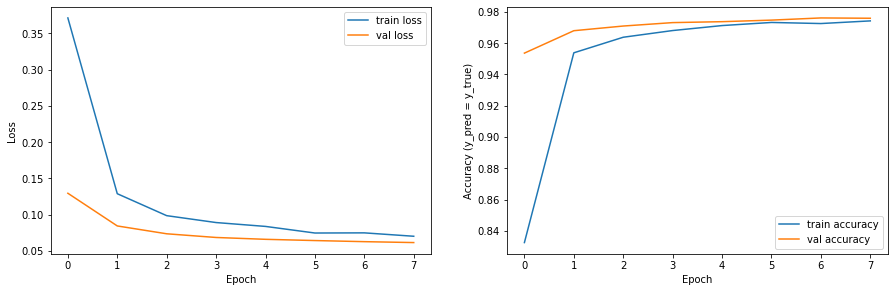

In [31]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [32]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

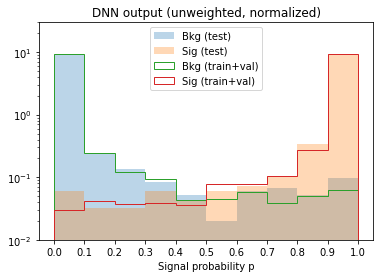

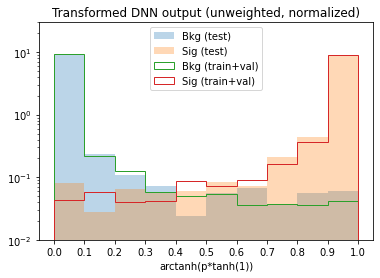

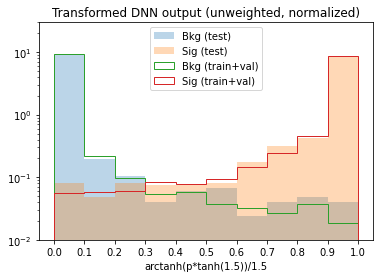

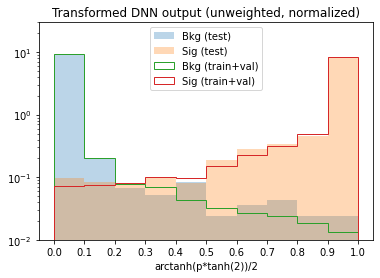

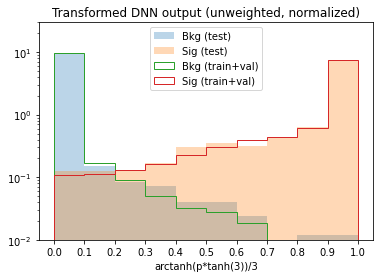

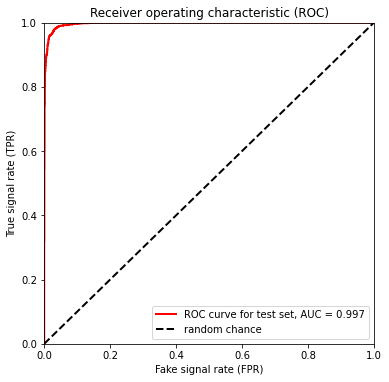

Test loss, test accuracy: [0.0715422780957001, 0.973720908164978]


In [34]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1.5))/1.5')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 128)
print("Test loss, test accuracy:", results)

## Save trained model

In [35]:
joblib.dump(scaler, 'trained_models_rerunBtag/et2b_scaler.gz')
model.save('trained_models_rerunBtag/et2b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/et2b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/et2b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE, THE BELOW CAN BE IGNORED)

## Load all root files one by one

In [ ]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/et18_raw/'
outfolder18 = 'root_outputs/et18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('etau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/et17_raw/'
outfolder17 = 'root_outputs/et17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('etau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/et16_raw/'
outfolder16 = 'root_outputs/et16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('etau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

## Feed to NN and write outputs to root files

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths16[i])